<div class="alert alert-block alert-success">
<b>PREP: </b>Scenario analysis
</div>

In [1]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m


def calculate_slack_for_scenario(scenario_data):
    """
    Calculate the slack metric for the given scenario.
    
    Slack is defined as:
        Slack = 1 - (total flight minutes in recovery period / total recovery period aircraft-minutes)
    
    A slack of 1 means no flights during recovery period.
    A slack of 0 means flights occupy the entire recovery period.
    """
    def time_to_minutes(timestr):
        # timestr format: "HH:MM"
        hh, mm = timestr.split(":")
        return int(hh) * 60 + int(mm)
    
    # Extract scenario start/end times
    # We assume the same date for start and end for simplicity.
    recovery_start_time_str = scenario_data["recovery_start_time"]  
    recovery_end_time_str = scenario_data["recovery_end_time"]      
    
    recovery_start_minutes = time_to_minutes(recovery_start_time_str)
    recovery_end_minutes = time_to_minutes(recovery_end_time_str)
    total_recovery_period_minutes = recovery_end_minutes - recovery_start_minutes
    
    total_aircraft = scenario_data["total_aircraft"]
    
    # Calculate total flight minutes within the recovery period
    flights = scenario_data["flights"]
    total_flights = len(flights)
    total_flight_minutes_in_recovery = 0
    total_flight_minutes_total = 0
    
    for flight_id, flight_data in flights.items():
        dep_time_str = flight_data["DepTime"]  
        arr_time_str = flight_data["ArrTime"] 
        
        dep_minutes = time_to_minutes(dep_time_str)
        arr_minutes = time_to_minutes(arr_time_str)
        
        total_flight_minutes_total += arr_minutes - dep_minutes
        overlap_start = max(dep_minutes, recovery_start_minutes)
        overlap_end = min(arr_minutes, recovery_end_minutes)
        
        if overlap_end > overlap_start:
            flight_overlap = overlap_end - overlap_start
        else:
            flight_overlap = 0
        
        total_flight_minutes_in_recovery += flight_overlap
    
    # Calculate total aircraft-minutes available during the recovery period
    total_recovery_aircraft_minutes = total_recovery_period_minutes * total_aircraft
    
    # Slack calculation
    if total_recovery_aircraft_minutes == 0:
        slack = 1.0
    else:
        slack = 1 - (total_flight_minutes_in_recovery / total_recovery_aircraft_minutes)
    
    return slack, total_flights, total_flight_minutes_total


def extract_disruption_stats(scenario_data):
    """
    Extract disruption statistics:
    - Count of fully disrupted (prob = 1.0)
    - Count of uncertain disruptions (0 < prob < 1.0)
    - Average probability across all aircraft (where an aircraft's probability is the max disruption probability it faces, 
      with 1.0 for fully disrupted and 0.0 if no disruption)
    - Average uncertainty probability (average of all disruptions where 0<prob<1.0, excluding 0 and 1)
    """
    disruptions_info = scenario_data.get('disruptions', {})
    disruptions_list = disruptions_info.get('disruptions', [])
    total_aircraft = disruptions_info.get('total_aircraft', 0)

    if total_aircraft == 0:
        # No aircraft or no disruptions
        return 0, 0, 0.0, 0.0

    fully_disrupted_count = sum(1 for d in disruptions_list if d.get('probability', 0.0) == 1.0)
    uncertain_disruptions = [d for d in disruptions_list if 0.0 < d.get('probability', 0.0) < 1.0]
    uncertain_count = len(uncertain_disruptions)

    aircraft_ids = scenario_data.get('aircraft_ids', [])
    ac_prob_map = {ac: 0.0 for ac in aircraft_ids}  
    
    for d in disruptions_list:
        ac_id = d.get('aircraft_id')
        p = d.get('probability', 0.0)
        # Keep the max probability for that aircraft
        if ac_id in ac_prob_map:
            ac_prob_map[ac_id] = max(ac_prob_map[ac_id], p)

    avg_ac_prob = sum(ac_prob_map.values()) / total_aircraft if total_aircraft > 0 else 0.0

    # Average uncertainty probability (only consider disruptions where 0<prob<1)
    if len(uncertain_disruptions) > 0:
        avg_uncertainty_prob = np.mean([d['probability'] for d in uncertain_disruptions])
    else:
        avg_uncertainty_prob = 0.0

    return fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertainty_prob, total_aircraft

# Path to the scenarios folder
scenario_folder_path = "../logs/scenarios/"
latest_folder = max(
    [f for f in os.listdir(scenario_folder_path) if f.startswith("scenario_folder_")],
    key=lambda x: int(x.split('_')[-1].replace('.json', ''))
)

latest_folder = "scenario_folder_scenario_4.json"

file_path = os.path.join(scenario_folder_path, latest_folder)

# Extract scenario ID
scenario_id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {scenario_id}")

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']


# Extract the data_folder (not strictly necessary for slack calculation, but we print it for context)
data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")

# Calculate slack and disruption stats for each scenario and store in a list of dicts
results = []
for scenario_name, scenario_data in scenarios.items():
    scenario_slack, total_flights, total_flight_minutes_total = calculate_slack_for_scenario(scenario_data)
    fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertain_prob, total_aircraft = extract_disruption_stats(scenario_data)
    results.append({
        "Scenario": scenario_name,
        "ScenarioSlack": scenario_slack,
        "TotalFlights": total_flights,
        "TotalFlightMinutes": total_flight_minutes_total,
        "FullyDisruptedCount": fully_disrupted_count,
        "UncertainCount": uncertain_count,
        "AvgAircraftProbability": avg_ac_prob,
        "AvgUncertaintyProbability": avg_uncertain_prob,
        "TotalAircraft": total_aircraft
    })

# Convert results to DataFrame
scenarios_df = pd.DataFrame(results)
print(scenarios_df)

# Save the slack results to CSV
# output_file = os.path.join(scenario_folder_path, f"scenario_slack_metrics_{scenario_id}.csv")
# scenarios_df.to_csv(output_file, index=False)
# print(f"Slack metrics saved to {output_file}")


Scenario ID: 4
Data Folder: ../data/Testing/6ac-700-diverse/
                          Scenario  ScenarioSlack  TotalFlights  \
0    deterministic_na_Scenario_001       0.349048            21   
1    deterministic_na_Scenario_002       0.369713            21   
2    deterministic_na_Scenario_003       0.420513            13   
3    deterministic_na_Scenario_004       0.441493            16   
4    deterministic_na_Scenario_005       0.484896            14   
..                             ...            ...           ...   
695        mixed_high_Scenario_096       0.479683            15   
696        mixed_high_Scenario_097       0.460082            13   
697        mixed_high_Scenario_098       0.424324            20   
698        mixed_high_Scenario_099       0.407037            15   
699        mixed_high_Scenario_100       0.428228            18   

     TotalFlightMinutes  FullyDisruptedCount  UncertainCount  \
0                  4101                    2               0   
1     

<div class="alert alert-block alert-success">
<b>RUN: </b>Inferencing
</div>

In [2]:
import os
import json
import time
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import time
%pip install stable-baselines3
from stable_baselines3 import DQN
from src.environment import AircraftDisruptionEnv
from scripts.utils import load_scenario_data, NumpyEncoder, get_training_metadata
from scripts.logger import create_new_id, log_inference_metadata, find_corresponding_training_id, convert_to_serializable

def run_inference_dqn_single(model_path, scenario_folder, env_type, seed):
    """
    Runs inference on a single scenario and returns the total reward.
    """
    start_time = time.time()
    data_dict = load_scenario_data(scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # print(f"*** initializing env with env_type: {env_type}")

    env = AircraftDisruptionEnv(
        aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict, env_type=env_type
    )

    model = DQN.load(model_path)
    model.set_env(env)
    model.policy.set_training_mode(False)
    model.exploration_rate = 0.0

    # Set seeds for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    obs, _ = env.reset()
    done_flag = False
    total_reward = 0
    step_num = 0
    max_steps = 1000

    while not done_flag and step_num < max_steps:
        action_mask = obs['action_mask']
        obs = {key: np.array(value, dtype=np.float32) for key, value in obs.items()}
        obs_tensor = model.policy.obs_to_tensor(obs)[0]
        q_values = model.policy.q_net(obs_tensor).detach().cpu().numpy().squeeze()

        masked_q_values = q_values.copy()
        masked_q_values[action_mask == 0] = -np.inf

        # If no valid actions remain, break out
        if np.all(np.isinf(masked_q_values)):
            break

        action = np.argmax(masked_q_values)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        done_flag = terminated or truncated
        step_num += 1

    total_delays = env.scenario_wide_delay_minutes
    total_cancelled_flights = env.scenario_wide_cancelled_flights
    end_time = time.time()
    scenario_time = end_time - start_time
    scenario_steps = env.scenario_wide_steps
    scenario_resolved_conflicts = env.scenario_wide_resolved_conflicts
    solution_slack = env.scenario_wide_solution_slack
    scenario_wide_tail_swaps = env.scenario_wide_tail_swaps
    scenario_wide_actual_disrupted_flights = env.scenario_wide_actual_disrupted_flights
    scenario_wide_reward_components = env.scenario_wide_reward_components

    return total_reward, total_delays, total_cancelled_flights, scenario_time, scenario_steps, scenario_resolved_conflicts, solution_slack, scenario_wide_tail_swaps, scenario_wide_actual_disrupted_flights, scenario_wide_reward_components


import os
from scripts.utils import load_scenario_data
from src.environment import AircraftDisruptionOptimizer
from scripts.visualizations import StatePlotter
from datetime import datetime
import time

def run_exact_single(scenario_folder, env_type):
    start_time = time.time()
    
    # Load scenario data first
    data_dict = load_scenario_data(scenario_folder)
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']
    
    # Parse recovery period times
    recovery_period = config_dict['RecoveryPeriod']
    start_datetime = datetime.strptime(f"{recovery_period['StartDate']} {recovery_period['StartTime']}", '%d/%m/%y %H:%M')
    end_datetime = datetime.strptime(f"{recovery_period['EndDate']} {recovery_period['EndTime']}", '%d/%m/%y %H:%M')
    
    # Initialize optimizer with loaded data
    if env_type == "greedy_reactive":
        optimizer = AircraftDisruptionGreedyReactive(
            aircraft_dict=aircraft_dict,
            flights_dict=flights_dict,
            rotations_dict=rotations_dict,
            alt_aircraft_dict=alt_aircraft_dict,
            config_dict=config_dict
        )
    elif env_type == "greedy_proactive":
        optimizer = AircraftDisruptionGreedyProactive(
            aircraft_dict=aircraft_dict,
            flights_dict=flights_dict,
            rotations_dict=rotations_dict,
            alt_aircraft_dict=alt_aircraft_dict,
            config_dict=config_dict
        )
    
    solution = optimizer.solve()
    
    # Convert optimizer solution to state plotter format
    swapped_flights = [(flight_id, new_aircraft) for flight_id, new_aircraft in solution['assignments'].items()]
    environment_delayed_flights = set(solution['delays'].keys())
    cancelled_flights = set(solution['cancellations'])
    
    # Update flights dict with delays
    updated_flights_dict = flights_dict.copy()
    for flight_id, delay in solution['delays'].items():
        if flight_id in updated_flights_dict:
            flight_info = updated_flights_dict[flight_id]
            flight_info['Delay'] = delay

    total_reward = optimizer.scenario_wide_reward_total
    total_delays = optimizer.scenario_wide_delay_minutes
    total_cancelled_flights = optimizer.scenario_wide_cancelled_flights
    scenario_steps = optimizer.scenario_wide_steps
    scenario_resolved_conflicts = optimizer.scenario_wide_resolved_conflicts
    solution_slack = optimizer.scenario_wide_solution_slack
    scenario_wide_tail_swaps = optimizer.scenario_wide_tail_swaps
    scenario_wide_actual_disrupted_flights = optimizer.scenario_wide_actual_disrupted_flights
    scenario_wide_reward_components = optimizer.scenario_wide_reward_components

    end_time = time.time()
    scenario_time = end_time - start_time

    return total_reward, total_delays, total_cancelled_flights, scenario_time, scenario_steps, scenario_resolved_conflicts, solution_slack, scenario_wide_tail_swaps, scenario_wide_actual_disrupted_flights, scenario_wide_reward_components


def run_inference_on_data_folder(model_paths, data_folder, seeds):
    """
    Runs inference on all scenarios found in 'data_folder', for each model in 'model_paths' and each seed in 'seeds'.

    Args:
        model_paths (list): List of tuples containing (model_path, env_type).
        data_folder (str): Path to the folder containing scenario subfolders.
        seeds (list): List of seeds for reproducibility.

    Returns:
        pd.DataFrame: A DataFrame containing scenario, model, seed, and total reward.
    """

    # Identify all scenario folders within data_folder
    scenario_folders = [
        os.path.join(data_folder, folder)
        for folder in os.listdir(data_folder)
        if os.path.isdir(os.path.join(data_folder, folder))
    ]

    total_combinations = len(scenario_folders) * len(model_paths) * len(seeds)
    print(f"Total combinations: {total_combinations}")
    current_combination = 0

    results = []
    for scenario_folder in scenario_folders:
        scenario_name = os.path.basename(scenario_folder)
        for model_tuple in model_paths:
            model_path, env_type = model_tuple  # Unpack the tuple correctly
            for seed in seeds:
                current_combination += 1
                print(f"({current_combination/total_combinations*100:.2f}%)")

                if env_type == "exact" or env_type == "greedy_proactive" or env_type == "greedy_reactive":
                    total_reward, total_delays, total_cancelled_flights, scenario_time, scenario_steps, scenario_resolved_conflicts, solution_slack, scenario_wide_tail_swaps, scenario_wide_actual_disrupted_flights, scenario_wide_reward_components = run_exact_single(scenario_folder, env_type)
                else:
                    total_reward, total_delays, total_cancelled_flights, scenario_time, scenario_steps, scenario_resolved_conflicts, solution_slack, scenario_wide_tail_swaps, scenario_wide_actual_disrupted_flights, scenario_wide_reward_components = run_inference_dqn_single(model_path, scenario_folder, env_type, seed)
                results.append({
                    "Scenario": scenario_name,
                    "Model": os.path.basename(model_path),
                    "Seed": seed,
                    "TotalReward": total_reward,
                    "TotalDelays": total_delays,
                    "TotalCancelledFlights": total_cancelled_flights,
                    "ScenarioTime": scenario_time,
                    "ScenarioSteps": scenario_steps,
                    "ScenarioResolvedConflicts": scenario_resolved_conflicts,
                    "SolutionSlack": solution_slack,
                    "TailSwaps": scenario_wide_tail_swaps,
                    "ActualDisruptedFlights": scenario_wide_actual_disrupted_flights,
                    "Reward_delay_penalty_total": scenario_wide_reward_components["delay_penalty_total"],
                    "Reward_cancel_penalty": scenario_wide_reward_components["cancel_penalty"],
                    "Reward_inaction_penalty": scenario_wide_reward_components["inaction_penalty"],
                    "Reward_proactive_bonus": scenario_wide_reward_components["proactive_bonus"],
                    "Reward_time_penalty": scenario_wide_reward_components["time_penalty"],
                    "Reward_final_conflict_resolution_reward": scenario_wide_reward_components["final_conflict_resolution_reward"]
                })

    results_df = pd.DataFrame(results)
    return results_df


# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

data_folder = data['data_folder']
print(f"inferencing on data folder: {data_folder}")

# Define models and seeds 
model_paths = [
    # ("../trained_models/dqn/6ac-700-diverse/1023/myopic-89.zip", "myopic"),
    ("../trained_models/dqn/6ac-700-diverse/1023/proactive-93.zip", "proactive"), 
    # ("../trained_models/dqn/6ac-700-diverse/1023/reactive-96.zip", "reactive"),
    ("../trained_models/dqn/6ac-700-diverse/1024/myopic-90.zip", "myopic"),
    # ("../trained_models/dqn/6ac-700-diverse/1024/proactive-92.zip", "proactive"), 
    ("../trained_models/dqn/6ac-700-diverse/1024/reactive-95.zip", "reactive"),
    # ("../trained_models/dqn/6ac-700-diverse/1025/myopic-91.zip", "myopic"),
    # ("../trained_models/dqn/6ac-700-diverse/1025/proactive-94.zip", "proactive"), 
    # ("../trained_models/dqn/6ac-700-diverse/1025/reactive-97.zip", "reactive"),
    ("greedy_proactive", "greedy_proactive"),
    ("greedy_reactive", "greedy_reactive")
]
# seeds = [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
seeds = []
for i in range(1, 11):
    seeds.append(i)

print(seeds)
# approx 2,5min per seed with 4 models

results_df = run_inference_on_data_folder(model_paths, data_folder, seeds)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
inferencing on data folder: ../data/Testing/6ac-700-diverse/
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Total combinations: 28000
(0.00%)
(0.01%)
(0.01%)
(0.01%)
(0.02%)
(0.02%)
(0.03%)
(0.03%)
(0.03%)
(0.04%)
(0.04%)
(0.04%)
(0.05%)
(0.05%)
(0.05%)
(0.06%)
(0.06%)
(0.06%)
(0.07%)
(0.07%)
(0.07%)
(0.08%)
(0.08%)
(0.09%)
(0.09%)
(0.09%)
(0.10%)
(0.10%)
(0.10%)
(0.11%)
(0.11%)
(0.11%)
(0.12%)
(0.12%)
(0.12%)
(0.13%)
(0.13%)
(0.14%)
(0.14%)
(0.14%)
(0.15%)
(0.15%)
(0.15%)
(0.16%)
(0.16%)
(0.16%)
(0.17%)
(0.17%)
(0.18%)
(0.18%)
(0.18%)
(0.19%)
(0.19%)
(0.19%)
(0.20%)
(0.20%)
(0.20%)
(0.21%)
(0.21%)
(0.21%)
(0.22%)
(0.22%)
(0.22%)
(0.23%)
(0.23%)
(0.24%)
(0.24%)
(0.24%)
(0.25%)
(0.25%)
(0.25%)
(0.26%)
(0.26%)
(0.26%)
(0.27%)
(0.27%)
(0.27%)
(0.28%)
(0.28%)
(0.29%)
(0.29%)
(0.29%)
(0.30%)
(0.30%)
(0.30%)
(0.31%)
(0.31%)
(0.31%)


<div class="alert alert-block alert-success">
</br>
</br>
</br>
<b>DONE: </b>MERGED DATASET
</br>
</br>
</br>
</br>
</div>

In [27]:
# Merge scenario-level info from scenarios_df into results_df
merged_df = results_df.merge(scenarios_df, on='Scenario', how='left')

# Sort models in desired order
model_order = ['proactive', 'myopic', 'reactive', 'exact']
merged_df['Model_Type'] = merged_df['Model'].str.extract('(' + '|'.join(model_order) + ')')
merged_df = merged_df.sort_values('Model_Type')
merged_df = merged_df.drop('Model_Type', axis=1)
merged_df_backup = merged_df.copy()

print("Inference Results (After Merging):")
print(merged_df)

# Save the merged results to CSV
merged_output_file = os.path.join(scenario_folder_path, f"scenario_inference_metrics_{scenario_id}.csv")
merged_df.to_csv(merged_output_file, index=False)
print(f"Inference results with scenario info saved to {merged_output_file}")

# print all column names
print(merged_df.columns)


Inference Results (After Merging):
                            Scenario            Model  Seed  TotalReward  \
13999    stochastic_low_Scenario_093            exact    10       -217.6   
13072         mixed_low_Scenario_063            exact     3      24786.2   
13073         mixed_low_Scenario_063            exact     4      19799.3   
13074         mixed_low_Scenario_063            exact     5      24786.2   
13075         mixed_low_Scenario_063            exact     6      24786.2   
...                              ...              ...   ...          ...   
22866        mixed_high_Scenario_041  reactive-95.zip     7       3981.9   
22865        mixed_high_Scenario_041  reactive-95.zip     6     -46041.1   
22864        mixed_high_Scenario_041  reactive-95.zip     5     -46041.1   
15388         mixed_low_Scenario_080  reactive-95.zip     9     -26429.8   
22664  deterministic_na_Scenario_059  reactive-95.zip     5      -4476.0   

       TotalDelays  TotalCancelledFlights  ScenarioT

/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_91250/3482191049.py:11: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = (merged_df['ActualDisruptedFlights'] == 0) & (merged_df['Model'].str.contains('^(exact|reactive)', regex=True))


<div class="alert alert-block alert-info">
<b>Check: </b>Comparison of Models Across All Scenarios
</div>

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Define model colors and order
model_order = ['proactive', 'myopic', 'reactive', 'exact']
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green' if 'exact' not in model_name.lower() else
        'darkgrey',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in merged_df['Model'].unique()
}

# First aggregate by Model and Seed, then calculate mean and std across seeds
comparison_table = (
    merged_df
    .groupby(['Model', 'Seed'])
    .agg(
        TotalReward=('TotalReward', 'mean'),
        ScenarioTime=('ScenarioTime', 'mean'), 
        ScenarioSteps=('ScenarioSteps', 'mean'),
        TotalDelays=('TotalDelays', 'mean'),
        TotalCancelledFlights=('TotalCancelledFlights', 'mean')
    )
    .groupby('Model')
    .agg(
        Mean_Reward=('TotalReward', 'mean'),
        Std_Reward=('TotalReward', 'std'),
        Mean_Runtime=('ScenarioTime', 'mean'),
        Std_Runtime=('ScenarioTime', 'std'),
        Mean_Steps=('ScenarioSteps', 'mean'),
        Std_Steps=('ScenarioSteps', 'std'),
        Mean_Delays=('TotalDelays', 'mean'),
        Std_Delays=('TotalDelays', 'std'),
        Mean_CancelledFlights=('TotalCancelledFlights', 'mean'),
        Std_CancelledFlights=('TotalCancelledFlights', 'std')
    )
    .round(2)
)

# Sort the comparison table according to model order
comparison_table['Model_Type'] = comparison_table.index.map(lambda x: next(m for m in model_order if m in x.lower()))
comparison_table = comparison_table.sort_values('Model_Type')
comparison_table = comparison_table.drop('Model_Type', axis=1)

print("Comparison of Models Across All Scenarios:")
print(comparison_table)


Comparison of Models Across All Scenarios:
                  Mean_Reward  Std_Reward  Mean_Runtime  Std_Runtime  \
Model                                                                  
exact                32933.36      268.93          0.17          0.0   
myopic-90.zip         2229.14      597.76          0.03          0.0   
proactive-93.zip      6625.31      527.26          0.03          0.0   
reactive-95.zip      -7653.88      467.11          0.03          0.0   

                  Mean_Steps  Std_Steps  Mean_Delays  Std_Delays  \
Model                                                              
exact                   6.90       0.02        20.28        1.76   
myopic-90.zip           7.67       0.03       334.02        3.37   
proactive-93.zip        7.52       0.04       372.54        2.34   
reactive-95.zip         7.90       0.04       222.09        5.59   

                  Mean_CancelledFlights  Std_CancelledFlights  
Model                                              

<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Overall reward comparison
</br>
</br>
</br>
</div>

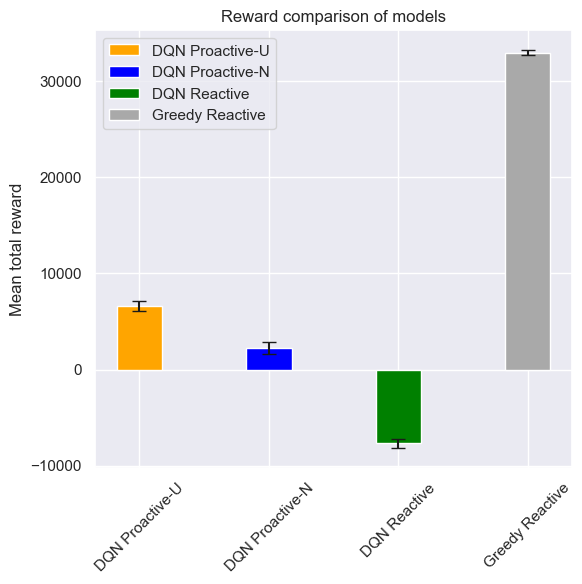

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bar plot with error bars
fig, ax = plt.subplots(figsize=(6, 6))

# Define desired order of models
model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']

# Sort comparison table by desired order
sorted_models = sorted(comparison_table.index, 
                      key=lambda x: model_order.index(model_colors[x][1]))

x = range(len(sorted_models))
width = 0.35

# Plot bars using model colors in specified order
for i, model in enumerate(sorted_models):
    color = model_colors[model][0]  # Get color from model_colors dictionary
    label = model_colors[model][1]  # Get label from model_colors dictionary
    ax.bar(i, comparison_table.loc[model, 'Mean_Reward'], width,
           yerr=comparison_table.loc[model, 'Std_Reward'],
           capsize=5, label=label, color=color)

ax.set_ylabel('Mean total reward')
ax.set_title('Reward comparison of models')
ax.set_xticks(x)
ax.set_xticklabels([model_colors[model][1] for model in sorted_models], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


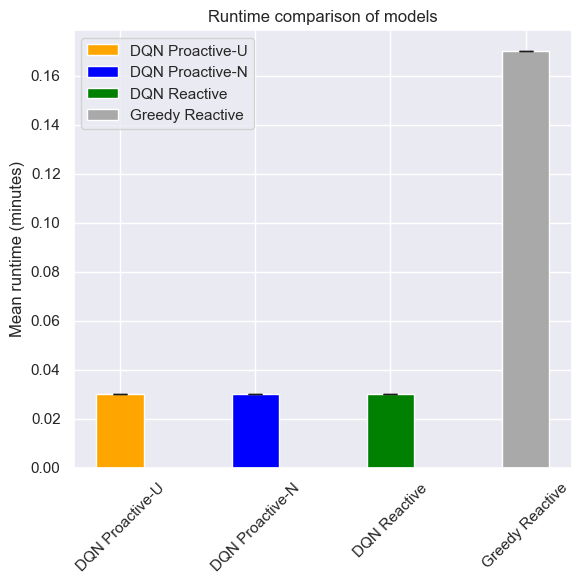

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bar plot with error bars
fig, ax = plt.subplots(figsize=(6, 6))

# Define desired order of models
model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']

# Sort comparison table by desired order
sorted_models = sorted(comparison_table.index, 
                      key=lambda x: model_order.index(model_colors[x][1]))

x = range(len(sorted_models))
width = 0.35

# Plot bars using model colors in specified order
for i, model in enumerate(sorted_models):
    color = model_colors[model][0]  # Get color from model_colors dictionary
    label = model_colors[model][1]  # Get label from model_colors dictionary
    ax.bar(i, comparison_table.loc[model, 'Mean_Runtime'], width,
           yerr=comparison_table.loc[model, 'Std_Runtime'],
           capsize=5, label=label, color=color)

ax.set_ylabel('Mean runtime (minutes)')
ax.set_title('Runtime comparison of models')
ax.set_xticks(x)
ax.set_xticklabels([model_colors[model][1] for model in sorted_models], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Overall cancellations comparison
</br>
</br>
</br>
</div>

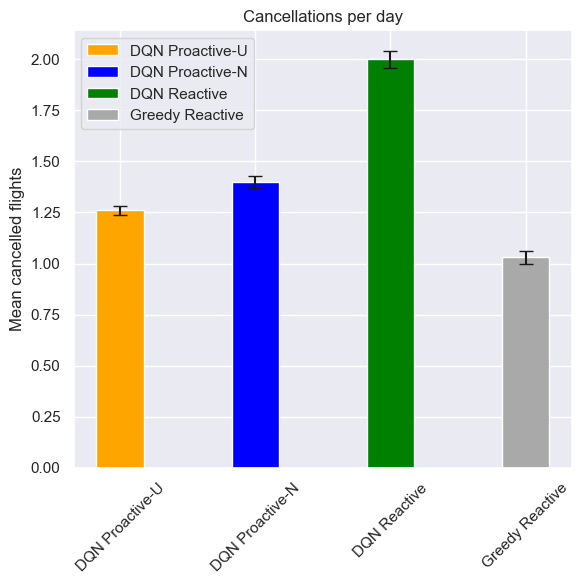

In [31]:
# Create bar plot with error bars
fig, ax = plt.subplots(figsize=(6, 6))

# Sort comparison table by desired order
sorted_models = sorted(comparison_table.index, 
                      key=lambda x: model_order.index(model_colors[x][1]))

x = range(len(sorted_models))
width = 0.35

# Plot bars using model colors in specified order
for i, model in enumerate(sorted_models):
    color = model_colors[model][0]  # Get color from model_colors dictionary
    label = model_colors[model][1]  # Get label from model_colors dictionary
    ax.bar(i, comparison_table.loc[model, 'Mean_CancelledFlights'], width,
           yerr=comparison_table.loc[model, 'Std_CancelledFlights'],
           capsize=5, label=label, color=color)

ax.set_ylabel('Mean cancelled flights')
ax.set_title('Cancellations per day')
ax.set_xticks(x)
ax.set_xticklabels([model_colors[model][1] for model in sorted_models], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Overall delay comparison
</br>
</br>
</br>
</div>

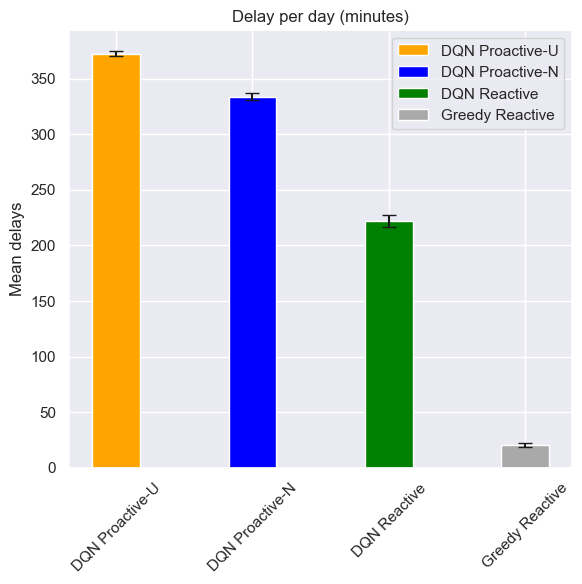

In [32]:
# Create bar plot with error bars
fig, ax = plt.subplots(figsize=(6, 6))

# Sort comparison table by desired order
sorted_models = sorted(comparison_table.index,
                      key=lambda x: model_order.index(model_colors[x][1]))

x = range(len(sorted_models))
width = 0.35

# Plot bars using model colors in specified order
for i, model in enumerate(sorted_models):
    color = model_colors[model][0]  # Get color from model_colors dictionary
    label = model_colors[model][1]  # Get label from model_colors dictionary
    ax.bar(i, comparison_table.loc[model, 'Mean_Delays'], width,
           yerr=comparison_table.loc[model, 'Std_Delays'],
           capsize=5, label=label, color=color)

ax.set_ylabel('Mean delays')
ax.set_title('Delay per day (minutes)')
ax.set_xticks(x)
ax.set_xticklabels([model_colors[model][1] for model in sorted_models], rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>T-Tests
</br>
</br>
</br>
</div>

In [33]:
import pandas as pd
from scipy.stats import ttest_rel, shapiro

print("T-test")
print("Null hypothesis: DQN Proactive obtains equal reward as DQN Reactive")
print("Alternative hypothesis: DQN Proactive obtains higher reward than DQN Reactive")


# Filter for only the proactive and reactive models
proactive_df = merged_df[merged_df['Model'].str.contains("proactive", case=False, regex=False)]
reactive_df = merged_df[merged_df['Model'].str.contains("reactive", case=False, regex=False)]

# Ensure we only compare scenario-seed pairs that exist in both datasets
common_keys = pd.merge(
    proactive_df[['Scenario', 'Seed']],
    reactive_df[['Scenario', 'Seed']],
    on=['Scenario', 'Seed'],
    how='inner'
)

proactive_common = pd.merge(proactive_df, common_keys, on=['Scenario', 'Seed'], how='inner')
reactive_common = pd.merge(reactive_df, common_keys, on=['Scenario', 'Seed'], how='inner')

# Sort by scenario and seed to ensure alignment
proactive_common = proactive_common.sort_values(by=['Scenario', 'Seed'])
reactive_common = reactive_common.sort_values(by=['Scenario', 'Seed'])

# Extract the TotalReward arrays
proactive_rewards = proactive_common['TotalReward'].values
reactive_rewards = reactive_common['TotalReward'].values

# Calculate the differences
differences = proactive_rewards - reactive_rewards

# Number of matched pairs is scenarios * seeds
num_scenarios = merged_df['Scenario'].nunique()
num_seeds = len(seeds)
matched_pairs_count = len(differences)  # This should match num_scenarios * num_seeds
print(f"Number of matched pairs: {matched_pairs_count} (scenarios * num_seeds)")

# Normality test (Shapiro-Wilk test)
shapiro_stat, shapiro_p = shapiro(differences)
print("\nShapiro-Wilk Normality Test for Differences:")
print(f"Statistic: {shapiro_stat}, p-value: {shapiro_p}")

if shapiro_p < 0.05:
    print("The distribution of differences is not normal (p < 0.05). This may affect the validity of the t-test assumptions.")
else:
    print("The distribution of differences appears normal (p >= 0.05). The t-test assumptions are more likely to be met.")

# Perform a paired t-test
t_stat, p_value = ttest_rel(proactive_rewards, reactive_rewards)

print("\nPaired T-Test Results (Proactive vs Reactive on TotalReward):")
print(f"T-Statistic: {t_stat}")
print(f"P-Value (two-tailed): {p_value}")

# One-tailed test interpretation (proactive > reactive)
if t_stat > 0:
    one_tailed_p_value = p_value / 2.0
    print(f"One-tailed P-Value (Proactive > Reactive): {one_tailed_p_value}")
else:
    one_tailed_p_value = 1.0  # If t_stat is not in the expected direction, one-tailed p-value interpretation is moot.
    print("One-tailed direction does not align with the hypothesis that proactive > reactive.")

# Conclusion based on the one-tailed test
print("\nConclusions:")
if one_tailed_p_value < 0.05:
    print("We reject the null hypothesis. There is significant evidence that the proactive model outperforms the reactive model.")
else:
    print("We fail to reject the null hypothesis. We do not have sufficient evidence that the proactive model outperforms the reactive model.")

# Print LaTeX table
print("\nLaTeX Table:")
print(r"\begin{table}[h!]")
print(r"\centering")
print(r"\renewcommand{\arraystretch}{1.2}")
print(r"\begin{tabular}{lc}")
print(r"\toprule")
print(r"\textbf{Metric} & \textbf{Value} \\ \midrule")
print(f"Matched pairs (scenarios $\\times$ seeds) & {matched_pairs_count:,} \\\\")
print(f"Shapiro-Wilk statistic & {shapiro_stat:.3f} \\\\")
print(f"Shapiro-Wilk $p$-value & {shapiro_p:.2e} \\\\")
print(f"Paired t-test statistic & {t_stat:.1f} \\\\")
print(f"Two-tailed $p$-value & {p_value:.3e} \\\\")
print(f"One-tailed $p$-value & {one_tailed_p_value:.3e} \\\\")
print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\caption{Summary of Statistical Results}")
print(r"\label{tab:test_results}")
print(r"\end{table}")


T-test
Null hypothesis: DQN Proactive obtains equal reward as DQN Reactive
Alternative hypothesis: DQN Proactive obtains higher reward than DQN Reactive
Number of matched pairs: 7000 (scenarios * num_seeds)

Shapiro-Wilk Normality Test for Differences:
Statistic: 0.9890006406306177, p-value: 6.426055805243105e-23
The distribution of differences is not normal (p < 0.05). This may affect the validity of the t-test assumptions.

Paired T-Test Results (Proactive vs Reactive on TotalReward):
T-Statistic: 32.65673800986876
P-Value (two-tailed): 7.458337643238673e-218
One-tailed P-Value (Proactive > Reactive): 3.7291688216193366e-218

Conclusions:
We reject the null hypothesis. There is significant evidence that the proactive model outperforms the reactive model.

LaTeX Table:
\begin{table}[h!]
\centering
\renewcommand{\arraystretch}{1.2}
\begin{tabular}{lc}
\toprule
\textbf{Metric} & \textbf{Value} \\ \midrule
Matched pairs (scenarios $\times$ seeds) & 7,000 \\
Shapiro-Wilk statistic & 0.989

/Users/pieterbecking/Desktop/Boeing-ADM-DRL-Github/.venv2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7000.
  res = hypotest_fun_out(*samples, **kwds)


In [34]:
import pandas as pd
from scipy.stats import ttest_rel, shapiro

print("T-test")
print("Null hypothesis: DQN Proactive obtains equal delays as DQN Reactive") 
print("Alternative hypothesis: DQN Proactive obtains lower delays than DQN Reactive")

# Filter for only the proactive and reactive models
proactive_df = merged_df[merged_df['Model'].str.contains("proactive", case=False, regex=False)]
reactive_df = merged_df[merged_df['Model'].str.contains("reactive", case=False, regex=False)]

# Ensure we only compare scenario-seed pairs that exist in both datasets
common_keys = pd.merge(
    proactive_df[['Scenario', 'Seed']],
    reactive_df[['Scenario', 'Seed']],
    on=['Scenario', 'Seed'],
    how='inner'
)

proactive_common = pd.merge(proactive_df, common_keys, on=['Scenario', 'Seed'], how='inner')
reactive_common = pd.merge(reactive_df, common_keys, on=['Scenario', 'Seed'], how='inner')

# Sort by scenario and seed to ensure alignment
proactive_common = proactive_common.sort_values(by=['Scenario', 'Seed'])
reactive_common = reactive_common.sort_values(by=['Scenario', 'Seed'])

# Extract the TotalDelays arrays
proactive_delays = proactive_common['TotalDelays'].values
reactive_delays = reactive_common['TotalDelays'].values

# Calculate the differences
differences = proactive_delays - reactive_delays

# Number of matched pairs is scenarios * seeds
num_scenarios = merged_df['Scenario'].nunique()
num_seeds = len(seeds)
matched_pairs_count = len(differences)  # This should match num_scenarios * num_seeds
print(f"Number of matched pairs: {matched_pairs_count} (scenarios * num_seeds)")

# Normality test (Shapiro-Wilk test)
shapiro_stat, shapiro_p = shapiro(differences)
print("\nShapiro-Wilk Normality Test for Differences:")
print(f"Statistic: {shapiro_stat}, p-value: {shapiro_p}")

if shapiro_p < 0.05:
    print("The distribution of differences is not normal (p < 0.05). This may affect the validity of the t-test assumptions.")
else:
    print("The distribution of differences appears normal (p >= 0.05). The t-test assumptions are more likely to be met.")

# Perform a paired t-test
t_stat, p_value = ttest_rel(proactive_delays, reactive_delays)

print("\nPaired T-Test Results (Proactive vs Reactive on TotalDelays):")
print(f"T-Statistic: {t_stat}")
print(f"P-Value (two-tailed): {p_value}")

# One-tailed test interpretation (proactive < reactive)
if t_stat < 0:
    one_tailed_p_value = p_value / 2.0
    print(f"One-tailed P-Value (Proactive < Reactive): {one_tailed_p_value}")
else:
    # print the t_stat
    one_tailed_p_value = 1.0  # If t_stat is not in the expected direction, one-tailed p-value interpretation is moot.
    print("One-tailed direction does not align with the hypothesis that proactive < reactive.")

# Conclusion based on the one-tailed test
print("\nConclusions:")
if one_tailed_p_value < 0.05:
    print("We reject the null hypothesis. There is significant evidence that the proactive model has lower delays than the reactive model.")
else:
    print("We fail to reject the null hypothesis. We do not have sufficient evidence that the proactive model has lower delays than the reactive model.")

# Print LaTeX table
print("\nLaTeX Table:")
print(r"\begin{table}[h!]")
print(r"\centering")
print(r"\renewcommand{\arraystretch}{1.2}")
print(r"\begin{tabular}{lc}")
print(r"\toprule")
print(r"\textbf{Metric} & \textbf{Value} \\ \midrule")
print(f"Matched pairs (scenarios $\\times$ seeds) & {matched_pairs_count:,} \\\\")
print(f"Shapiro-Wilk statistic & {shapiro_stat:.3f} \\\\")
print(f"Shapiro-Wilk $p$-value & {shapiro_p:.2e} \\\\")
print(f"Paired t-test statistic & {t_stat:.1f} \\\\")
print(f"Two-tailed $p$-value & {p_value:.3e} \\\\")
print(f"One-tailed $p$-value & {one_tailed_p_value:.3e} \\\\")
print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\caption{Summary of Statistical Results}")
print(r"\label{tab:test_results}")
print(r"\end{table}")


T-test
Null hypothesis: DQN Proactive obtains equal delays as DQN Reactive
Alternative hypothesis: DQN Proactive obtains lower delays than DQN Reactive
Number of matched pairs: 7000 (scenarios * num_seeds)

Shapiro-Wilk Normality Test for Differences:
Statistic: 0.9359631802732566, p-value: 1.151628611332395e-47
The distribution of differences is not normal (p < 0.05). This may affect the validity of the t-test assumptions.

Paired T-Test Results (Proactive vs Reactive on TotalDelays):
T-Statistic: 27.953407148336275
P-Value (two-tailed): 4.1832500466162145e-163
One-tailed direction does not align with the hypothesis that proactive < reactive.

Conclusions:
We fail to reject the null hypothesis. We do not have sufficient evidence that the proactive model has lower delays than the reactive model.

LaTeX Table:
\begin{table}[h!]
\centering
\renewcommand{\arraystretch}{1.2}
\begin{tabular}{lc}
\toprule
\textbf{Metric} & \textbf{Value} \\ \midrule
Matched pairs (scenarios $\times$ seeds) &

/Users/pieterbecking/Desktop/Boeing-ADM-DRL-Github/.venv2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7000.
  res = hypotest_fun_out(*samples, **kwds)


In [35]:
import pandas as pd
from scipy.stats import ttest_rel, shapiro

print("T-test")
print("Null hypothesis: DQN Proactive obtains equal cancelled flights as DQN Reactive") 
print("Alternative hypothesis: DQN Proactive obtains lower cancelled flights than DQN Reactive")

# Filter for only the proactive and reactive models
proactive_df = merged_df[merged_df['Model'].str.contains("proactive", case=False, regex=False)]
reactive_df = merged_df[merged_df['Model'].str.contains("reactive", case=False, regex=False)]

# Ensure we only compare scenario-seed pairs that exist in both datasets
common_keys = pd.merge(
    proactive_df[['Scenario', 'Seed']],
    reactive_df[['Scenario', 'Seed']],
    on=['Scenario', 'Seed'],
    how='inner'
)

proactive_common = pd.merge(proactive_df, common_keys, on=['Scenario', 'Seed'], how='inner')
reactive_common = pd.merge(reactive_df, common_keys, on=['Scenario', 'Seed'], how='inner')

# Sort by scenario and seed to ensure alignment
proactive_common = proactive_common.sort_values(by=['Scenario', 'Seed'])
reactive_common = reactive_common.sort_values(by=['Scenario', 'Seed'])

# Extract the TotalCancelledFlights arrays
proactive_cancellations = proactive_common['TotalCancelledFlights'].values
reactive_cancellations = reactive_common['TotalCancelledFlights'].values

# Calculate the differences
differences = proactive_cancellations - reactive_cancellations

# Number of matched pairs is scenarios * seeds
num_scenarios = merged_df['Scenario'].nunique()
num_seeds = len(seeds)
matched_pairs_count = len(differences)  # This should match num_scenarios * num_seeds
print(f"Number of matched pairs: {matched_pairs_count} (scenarios * num_seeds)")

# Normality test (Shapiro-Wilk test)
shapiro_stat, shapiro_p = shapiro(differences)
print("\nShapiro-Wilk Normality Test for Differences:")
print(f"Statistic: {shapiro_stat}, p-value: {shapiro_p}")

if shapiro_p < 0.05:
    print("The distribution of differences is not normal (p < 0.05). This may affect the validity of the t-test assumptions.")
else:
    print("The distribution of differences appears normal (p >= 0.05). The t-test assumptions are more likely to be met.")

# Perform a paired t-test
t_stat, p_value = ttest_rel(proactive_cancellations, reactive_cancellations)

print("\nPaired T-Test Results (Proactive vs Reactive on TotalCancelledFlights):")
print(f"T-Statistic: {t_stat}")
print(f"P-Value (two-tailed): {p_value}")

# One-tailed test interpretation (proactive < reactive)
if t_stat < 0:
    one_tailed_p_value = p_value / 2.0
    print(f"One-tailed P-Value (Proactive < Reactive): {one_tailed_p_value}")
else:
    # print the t_stat
    one_tailed_p_value = 1.0  # If t_stat is not in the expected direction, one-tailed p-value interpretation is moot.
    print("One-tailed direction does not align with the hypothesis that proactive < reactive.")

# Conclusion based on the one-tailed test
print("\nConclusions:")
if one_tailed_p_value < 0.05:
    print("We reject the null hypothesis. There is significant evidence that the proactive model has lower cancelled flights than the reactive model.")
else:
    print("We fail to reject the null hypothesis. We do not have sufficient evidence that the proactive model has lower cancelled flights than the reactive model.")

# Print LaTeX table
print("\nLaTeX Table:")
print(r"\begin{table}[h!]")
print(r"\centering")
print(r"\renewcommand{\arraystretch}{1.2}")
print(r"\begin{tabular}{lc}")
print(r"\toprule")
print(r"\textbf{Metric} & \textbf{Value} \\ \midrule")
print(f"Matched pairs (scenarios $\\times$ seeds) & {matched_pairs_count:,} \\\\")
print(f"Shapiro-Wilk statistic & {shapiro_stat:.3f} \\\\")
print(f"Shapiro-Wilk $p$-value & {shapiro_p:.2e} \\\\")
print(f"Paired t-test statistic & {t_stat:.1f} \\\\")
print(f"Two-tailed $p$-value & {p_value:.3e} \\\\")
print(f"One-tailed $p$-value & {one_tailed_p_value:.3e} \\\\")
print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\caption{Summary of Statistical Results}")
print(r"\label{tab:test_results}")
print(r"\end{table}")


T-test
Null hypothesis: DQN Proactive obtains equal cancelled flights as DQN Reactive
Alternative hypothesis: DQN Proactive obtains lower cancelled flights than DQN Reactive
Number of matched pairs: 7000 (scenarios * num_seeds)

Shapiro-Wilk Normality Test for Differences:
Statistic: 0.9521890000038825, p-value: 6.562176406997625e-43
The distribution of differences is not normal (p < 0.05). This may affect the validity of the t-test assumptions.

Paired T-Test Results (Proactive vs Reactive on TotalCancelledFlights):
T-Statistic: -43.729037956188066
P-Value (two-tailed): 0.0
One-tailed P-Value (Proactive < Reactive): 0.0

Conclusions:
We reject the null hypothesis. There is significant evidence that the proactive model has lower cancelled flights than the reactive model.

LaTeX Table:
\begin{table}[h!]
\centering
\renewcommand{\arraystretch}{1.2}
\begin{tabular}{lc}
\toprule
\textbf{Metric} & \textbf{Value} \\ \midrule
Matched pairs (scenarios $\times$ seeds) & 7,000 \\
Shapiro-Wilk st

/Users/pieterbecking/Desktop/Boeing-ADM-DRL-Github/.venv2/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7000.
  res = hypotest_fun_out(*samples, **kwds)


<div class="alert alert-block alert-info">
</br>
</br>
<b>INFO: </b>Top 5 outperformances
</br>
</br>
</br>
</div>

In [36]:
import pandas as pd

# First calculate mean reward per scenario-model-seed combination
scenario_model_seed_avgs = (
    merged_df
    .groupby(['Scenario', 'Model', 'Seed'])['TotalReward']
    .mean()
    .reset_index()
)

# Then average over seeds to get scenario-model averages
scenario_model_avgs = (
    scenario_model_seed_avgs
    .groupby(['Scenario', 'Model'])['TotalReward']
    .mean()
    .reset_index()
)

# For each scenario, find best and second best models based on seed-averaged rewards
scenario_rankings = (
    scenario_model_avgs
    .groupby('Scenario')
    .apply(lambda x: pd.Series({
        'best_model': x.loc[x['TotalReward'].idxmax(), 'Model'],
        'best_reward': x['TotalReward'].max(),
        'second_best_reward': x['TotalReward'].nlargest(2).iloc[-1],
        'reward_difference': x['TotalReward'].max() - x['TotalReward'].nlargest(2).iloc[-1]
    }))
)

# Sort by reward difference and get top 5
top_5_differences = scenario_rankings.nlargest(5, 'reward_difference')

print("Top 5 scenarios with largest average performance gap between best and second best model (averaged over seeds):")
for idx, row in top_5_differences.iterrows():
    print(f"\nScenario: {idx}")
    print(f"Best performing model: {row['best_model']}")
    print(f"Average reward difference: {row['reward_difference']:.2f}")


Top 5 scenarios with largest average performance gap between best and second best model (averaged over seeds):

Scenario: mixed_medium_Scenario_012
Best performing model: exact
Average reward difference: 133731.00

Scenario: mixed_high_Scenario_078
Best performing model: exact
Average reward difference: 125498.50

Scenario: mixed_medium_Scenario_010
Best performing model: exact
Average reward difference: 124043.42

Scenario: deterministic_na_Scenario_019
Best performing model: exact
Average reward difference: 101225.20

Scenario: mixed_low_Scenario_033
Best performing model: exact
Average reward difference: 91555.66


/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_91250/279045478.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


<div class="alert alert-block alert-info">
</br>
</br>
<b>INFO: </b>Overall reward components
</br>
</br>
</br>
</div>

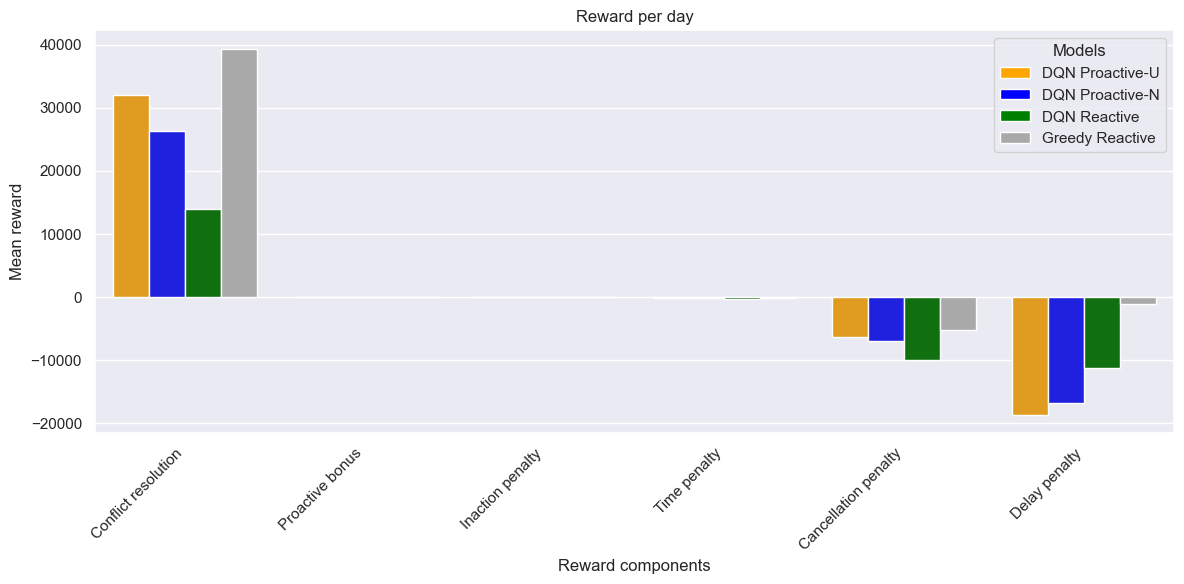

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Define reward components and their display names
reward_components = [
    'Reward_delay_penalty_total', 
    'Reward_cancel_penalty', 
    'Reward_inaction_penalty', 
    'Reward_proactive_bonus', 
    'Reward_time_penalty', 
    'Reward_final_conflict_resolution_reward'
]

component_display_names = {
    'Reward_delay_penalty_total': 'Delay penalty',
    'Reward_cancel_penalty': 'Cancellation penalty', 
    'Reward_inaction_penalty': 'Inaction penalty',
    'Reward_proactive_bonus': 'Proactive bonus',
    'Reward_time_penalty': 'Time penalty',
    'Reward_final_conflict_resolution_reward': 'Conflict resolution'
}

# Define model colors and order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green' if 'exact' not in model_name.lower() else
        'darkgrey',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in merged_df['Model'].unique()
}

# Sort models to ensure correct order
model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']
model_colors = {k: v for k, v in sorted(model_colors.items(), key=lambda x: model_order.index(x[1][1]))}

# Melt the DataFrame to reshape it for bar plotting
melted_df = merged_df.melt(
    id_vars=['Model'], 
    value_vars=reward_components,
    var_name='RewardComponent', 
    value_name='Reward'
)

# Map component names to display names
melted_df['RewardComponent'] = melted_df['RewardComponent'].map(component_display_names)

# Group by Model and RewardComponent to calculate the mean reward values
mean_rewards_df = melted_df.groupby(['Model', 'RewardComponent'], as_index=False).mean()

# Get the order of components based on Proactive-U values
proactive_u_values = mean_rewards_df[mean_rewards_df['Model'].str.contains('proactive', case=False) & 
                                   ~mean_rewards_df['Model'].str.contains('myopic', case=False)]
component_order = proactive_u_values.sort_values('Reward', ascending=False)['RewardComponent'].unique()

# Set figure size
plt.figure(figsize=(12, 6))

# Create custom legend handles
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color[0], label=color[1]) 
    for model, color in model_colors.items()
]

# Bar plot with custom colors and order
sns.barplot(
    data=mean_rewards_df,
    x='RewardComponent',
    y='Reward',
    hue='Model',
    hue_order=[k for k in model_colors.keys()],
    palette={model: color[0] for model, color in model_colors.items()},
    order=component_order
)

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.xlabel("Reward components")
plt.ylabel("Mean reward")
plt.title("Reward per day")

# Remove the auto-generated legend and add custom colored legend
plt.gca().legend_.remove()
plt.legend(handles=legend_elements, title="Models")

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Slack
</br>
</br>
</br>
</div>

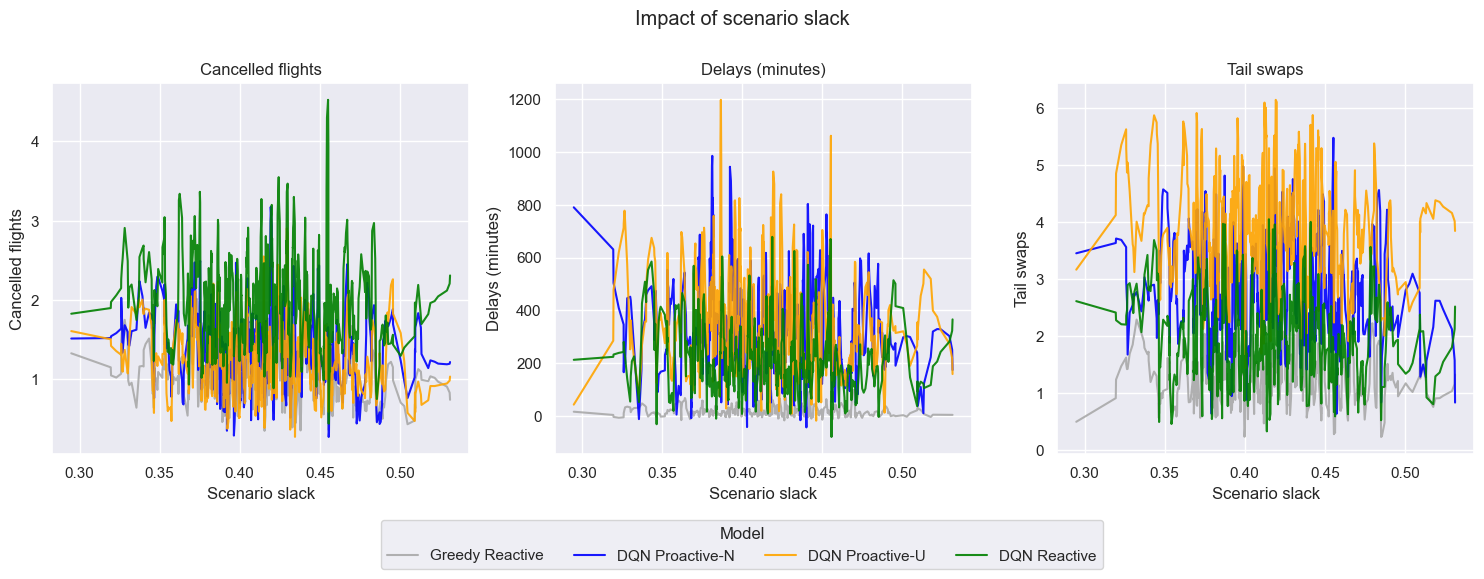

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import savgol_filter

# Define model colors and order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else 
        'green' if 'exact' not in model_name.lower() else
        'darkgrey',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in merged_df['Model'].unique()
}

# Define the metrics and corresponding y-axis labels in specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"), 
    ("TailSwaps", "Tail swaps")
]

# Aggregate data by taking the mean of the numeric metrics for each (Model, ScenarioSlack)
agg_df = (
    merged_df
    .groupby(['Model', 'ScenarioSlack'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Window size for smoothing (must be odd number)
window_size = 10  # Adjust this value to control smoothing amount

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Plot a line for each model
    for model_name, (color, label) in model_colors.items():
        model_data = agg_df[agg_df['Model'] == model_name].copy()
        # Sort by ScenarioSlack for a proper line plot
        model_data = model_data.sort_values(by='ScenarioSlack')
        
        x = model_data['ScenarioSlack']
        y = model_data[metric]
        
        # Only apply smoothing if we have enough data points
        if len(y) >= window_size:
            y_smoothed = savgol_filter(y, window_size, 2)  # 2 is polynomial order
        else:
            y_smoothed = y
            
        ax.plot(
            x,
            y_smoothed,
            label=label, 
            color=color,
            alpha=0.9
        )
        
    ax.set_xlabel("Scenario slack")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.grid(True)

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of scenario slack", y=1.02)
plt.show()

Number of unique scenarios in each bucket:
Bucket 0.00-0.05: 0 scenarios
Bucket 0.05-0.10: 0 scenarios
Bucket 0.10-0.15: 0 scenarios
Bucket 0.15-0.20: 0 scenarios
Bucket 0.20-0.25: 0 scenarios
Bucket 0.25-0.30: 1 scenarios
Bucket 0.30-0.35: 34 scenarios
Bucket 0.35-0.40: 223 scenarios
Bucket 0.40-0.45: 297 scenarios
Bucket 0.45-0.50: 128 scenarios
Bucket 0.50-0.55: 17 scenarios
Bucket 0.55-0.60: 0 scenarios
Bucket 0.60-0.65: 0 scenarios
Bucket 0.65-0.70: 0 scenarios
Bucket 0.70-0.75: 0 scenarios
Bucket 0.75-0.80: 0 scenarios
Bucket 0.80-0.85: 0 scenarios
Bucket 0.85-0.90: 0 scenarios
Bucket 0.90-0.95: 0 scenarios
Bucket 0.95-1.00: 0 scenarios


/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_91250/4251503232.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df


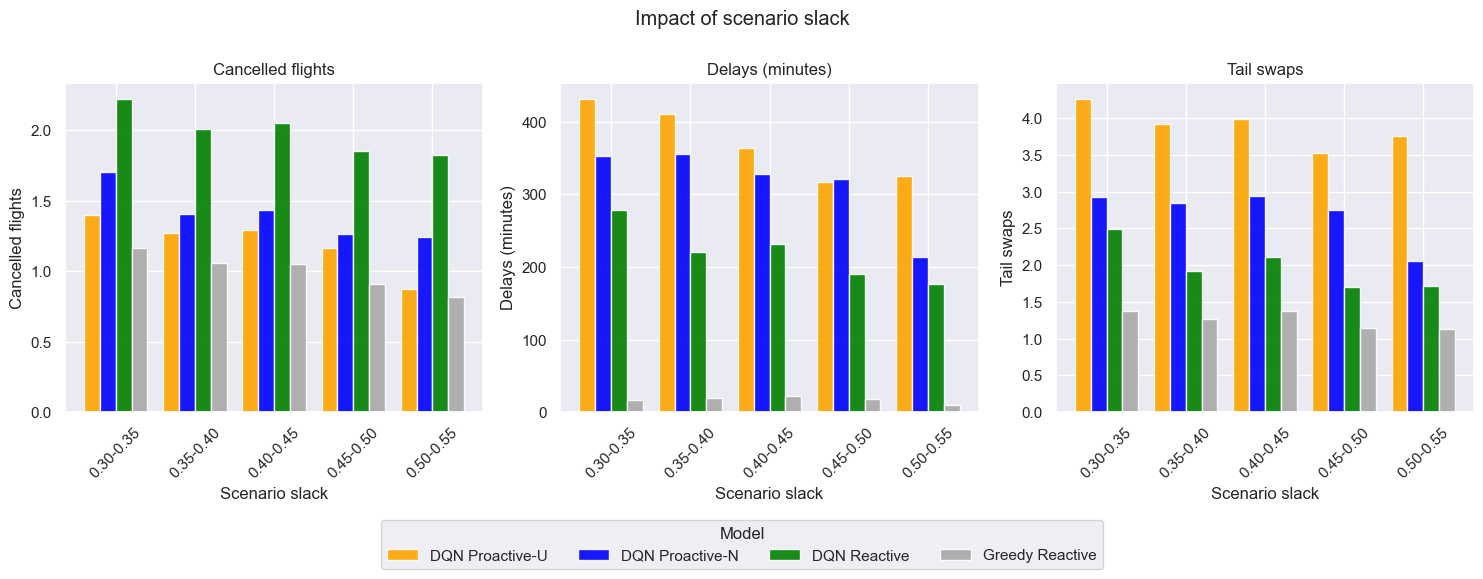

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else
        'darkgrey' if 'exact' in model_name.lower() else
        'green',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'myopic' in x.lower() else
                                        2 if 'reactive' in x.lower() else
                                        3))
}

# Define the metrics and corresponding y-axis labels in the specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps")
]

# Create slack buckets of size 0.05
bucket_size = 0.05
bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
bucket_labels = [f"{bucket_edges[i]:.2f}-{bucket_edges[i+1]:.2f}" for i in range(len(bucket_edges)-1)]

# Create slack intervals using the defined buckets
merged_df['SlackInterval'] = pd.cut(merged_df['ScenarioSlack'], 
                                    bins=bucket_edges,
                                    labels=bucket_labels,
                                    include_lowest=True)

# Print number of unique scenarios in each bucket
print("Number of unique scenarios in each bucket:")
for bucket in bucket_labels:
    scenario_count = merged_df[merged_df['SlackInterval'] == bucket]['Scenario'].nunique()
    print(f"Bucket {bucket}: {scenario_count} scenarios")

# Aggregate data by taking the mean of the numeric metrics for each (Model, SlackInterval)
agg_df = (
    merged_df
    .groupby(['Model', 'SlackInterval'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Remove rows where SlackInterval has no actual values
agg_df = agg_df.dropna(subset=['SlackInterval'])

# Define the display range for slack values
display_range = (0.3, 0.55)  # for example, only show intervals between 0.2 and 0.6

# Filter agg_df to only include intervals that lie fully within display_range
def interval_in_range(interval_label, low, high):
    start_str, end_str = interval_label.split('-')
    start_val = float(start_str)
    end_val = float(end_str)
    # Check if the entire interval lies within the specified range
    return start_val >= low and end_val <= high

agg_df = agg_df[agg_df['SlackInterval'].apply(lambda x: interval_in_range(x, display_range[0], display_range[1]))]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

bar_width = 0.2  # Reduced to accommodate 4 bars

# Get only the filtered slack intervals
slack_intervals = sorted(agg_df['SlackInterval'].unique())
x = np.arange(len(slack_intervals))

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Plot bars for each model in specific order
    model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']
    for j, desired_label in enumerate(model_order):
        # Find the model name that corresponds to this label
        matching_models = [name for name, (_, label) in model_colors.items() if label == desired_label]
        if not matching_models:
            continue
        model_name = matching_models[0]
        color = model_colors[model_name][0]
        
        model_data = agg_df[agg_df['Model'] == model_name]
        
        # Align model data with available slack intervals
        model_values = [
            model_data[model_data['SlackInterval'] == interval][metric].iloc[0]
            if not model_data[model_data['SlackInterval'] == interval].empty 
            else 0 
            for interval in slack_intervals
        ]
        
        ax.bar(x + j*bar_width, 
               model_values,
               bar_width,
               label=desired_label,
               color=color,
               alpha=0.9)
    
    ax.set_xlabel("Scenario slack")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.set_xticks(x + bar_width*1.5)  # Centered between bars
    ax.set_xticklabels(slack_intervals, rotation=45)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of scenario slack", y=1.02)
plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Impact of # disrupted flights
</br>
</br>
</br>
</div>


Number of unique scenarios per disrupted flights bucket:
Disrupted flights = 0: 306 scenarios
Disrupted flights = 1: 265 scenarios
Disrupted flights = 2: 453 scenarios
Disrupted flights = 3: 344 scenarios
Disrupted flights = 4: 206 scenarios
Disrupted flights = 5: 80 scenarios
Disrupted flights = 6: 11 scenarios


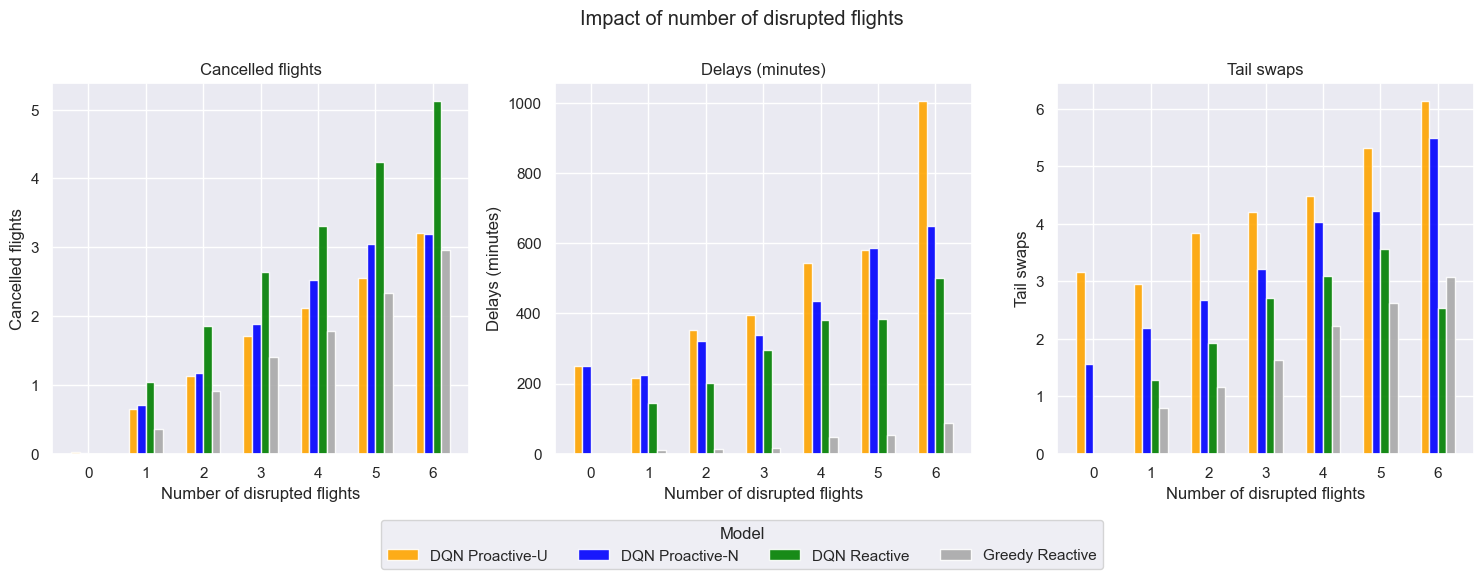

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else
        'darkgrey' if 'exact' in model_name.lower() else
        'green',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'myopic' in x.lower() else
                                        2 if 'reactive' in x.lower() else
                                        3))
}

# Define the metrics and corresponding y-axis labels in specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps")
]

# Print number of unique scenarios per disrupted flights bucket
print("\nNumber of unique scenarios per disrupted flights bucket:")
scenario_counts = merged_df.groupby('ActualDisruptedFlights')['Scenario'].nunique()
for n_disrupted, n_scenarios in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {n_scenarios} scenarios")

# Aggregate data by taking the mean of the numeric metrics for each (Model, ActualDisruptedFlights)
agg_df = (
    merged_df
    .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Calculate number of models and adjust bar width and spacing
    n_models = len(model_colors)
    bar_width = 0.15  # Reduced bar width to accommodate 4 bars
    total_width = bar_width * n_models
    start_offset = -total_width/2 + bar_width/2  # Center the group of bars
    
    # Plot bars for each model in the specified order
    bar_offset = start_offset
    for model_name, (color, label) in model_colors.items():
        model_data = agg_df[agg_df['Model'] == model_name].copy()
        # Sort by ActualDisruptedFlights
        model_data = model_data.sort_values(by='ActualDisruptedFlights')
        
        x = model_data['ActualDisruptedFlights']
        y = model_data[metric]
            
        ax.bar(
            x + bar_offset,  # Offset bars
            y,
            width=bar_width,
            label=label,
            color=color,
            alpha=0.9
        )
        bar_offset += bar_width  # Move to next position

    ax.set_xlabel("Number of disrupted flights")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of number of disrupted flights", y=1.02)
plt.show()



Number of unique scenarios per disrupted flights bucket:
Disrupted flights = 0: 306 scenarios
Disrupted flights = 1: 265 scenarios
Disrupted flights = 2: 453 scenarios
Disrupted flights = 3: 344 scenarios
Disrupted flights = 4: 206 scenarios
Disrupted flights = 5: 80 scenarios
Disrupted flights = 6: 11 scenarios


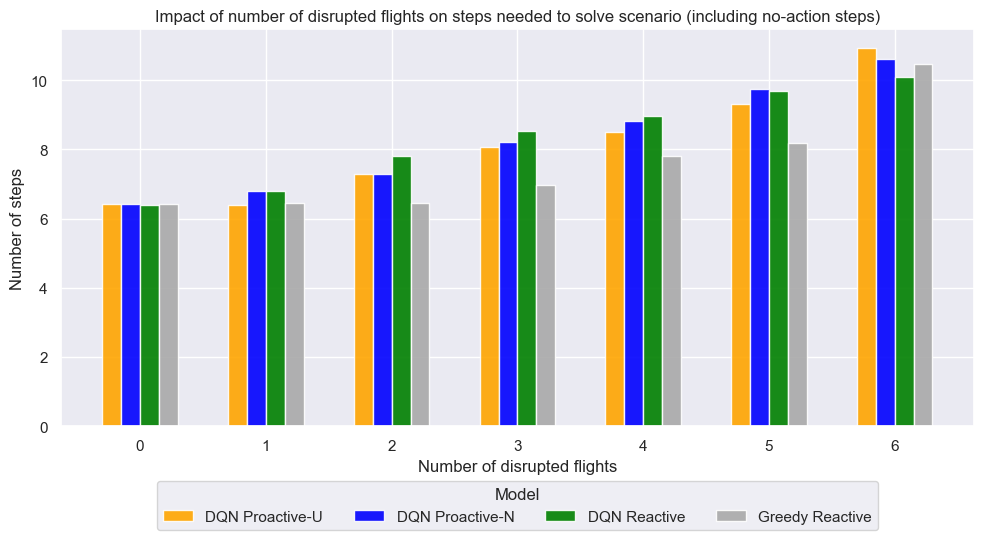

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else
        'darkgrey' if 'exact' in model_name.lower() else
        'green',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'myopic' in x.lower() else
                                        2 if 'reactive' in x.lower() else
                                        3))
}

# Print number of unique scenarios per disrupted flights bucket
print("\nNumber of unique scenarios per disrupted flights bucket:")
scenario_counts = merged_df.groupby('ActualDisruptedFlights')['Scenario'].nunique()
for n_disrupted, n_scenarios in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {n_scenarios} scenarios")

# Aggregate data by taking the mean of ScenarioSteps for each (Model, ActualDisruptedFlights)
agg_df = (
    merged_df
    .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[['ScenarioSteps']]
    .mean()
)

# Create a single figure
plt.figure(figsize=(10, 6))

# Calculate number of models and adjust bar width and spacing
n_models = len(model_colors)
bar_width = 0.15  # Reduced bar width to accommodate 4 bars
total_width = bar_width * n_models
start_offset = -total_width/2 + bar_width/2  # Center the group of bars

# Plot bars for each model in the specified order
bar_offset = start_offset
for model_name, (color, label) in model_colors.items():
    model_data = agg_df[agg_df['Model'] == model_name].copy()
    # Sort by ActualDisruptedFlights
    model_data = model_data.sort_values(by='ActualDisruptedFlights')
    
    x = model_data['ActualDisruptedFlights']
    y = model_data['ScenarioSteps']
        
    plt.bar(
        x + bar_offset,  # Offset bars
        y,
        width=bar_width,
        label=label,
        color=color,
        alpha=0.9
    )
    bar_offset += bar_width  # Move to next position

plt.xlabel("Number of disrupted flights")
plt.ylabel("Number of steps")
plt.title("Impact of number of disrupted flights on steps needed to solve scenario (including no-action steps)")
plt.grid(True, axis='y')

# Add legend
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.2), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Number of unique scenarios with 0 disrupted flights: 306
Number of unique scenarios with 1 disrupted flights: 265
Number of unique scenarios with 2 disrupted flights: 453
Number of unique scenarios with 3 disrupted flights: 344
Number of unique scenarios with 4 disrupted flights: 206
Number of unique scenarios with 5 disrupted flights: 80
Number of unique scenarios with 6 disrupted flights: 11


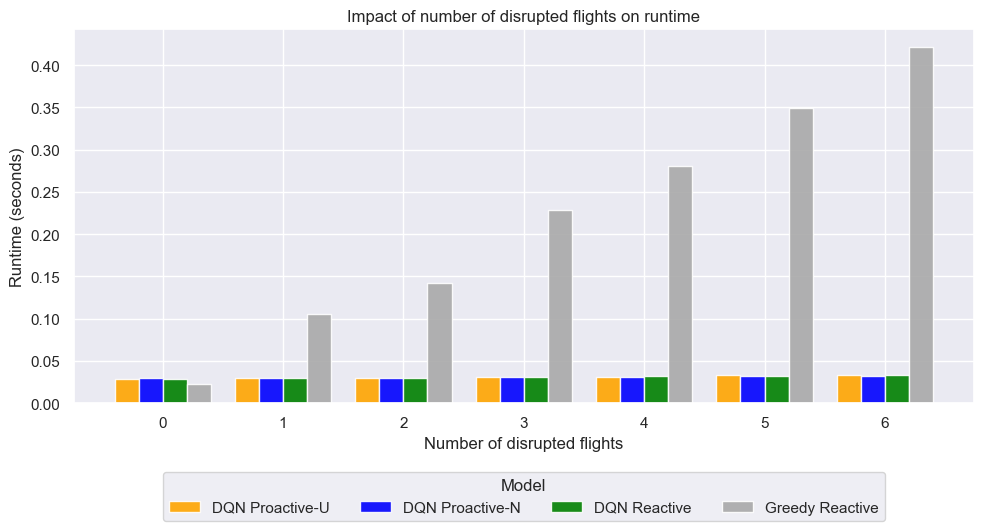

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else
        'darkgrey' if 'exact' in model_name.lower() else
        'green',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'myopic' in x.lower() else
                                        2 if 'reactive' in x.lower() else
                                        3))
}

# Print number of unique scenarios for each disrupted flights bucket
for n_disrupted in sorted(merged_df['ActualDisruptedFlights'].unique()):
    n_scenarios = len(merged_df[merged_df['ActualDisruptedFlights'] == n_disrupted]['Scenario'].unique())
    print(f"Number of unique scenarios with {n_disrupted} disrupted flights: {n_scenarios}")

# Aggregate data by taking the mean runtime for each (Model, ActualDisruptedFlights)
agg_df = (
    merged_df
    .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[['ScenarioTime']]
    .mean()
)

# Create a single figure
plt.figure(figsize=(10, 6))

# Calculate number of models and adjust bar width and spacing
n_models = len(model_colors)
bar_width = 0.2  # Width of each bar
total_width = bar_width * n_models
start_offset = -total_width/2 + bar_width/2  # Center the group of bars

# Plot bars for each model in the specified order
bar_offset = start_offset
for model_name, (color, label) in model_colors.items():
    model_data = agg_df[agg_df['Model'] == model_name].copy()
    # Sort by ActualDisruptedFlights
    model_data = model_data.sort_values(by='ActualDisruptedFlights')
    
    x = model_data['ActualDisruptedFlights']
    y = model_data['ScenarioTime']
        
    plt.bar(
        x + bar_offset,  # Offset bars
        y,
        width=bar_width,
        label=label,
        color=color,
        alpha=0.9
    )
    bar_offset += bar_width  # Move to next position

plt.xlabel("Number of disrupted flights")
plt.ylabel("Runtime (seconds)")
plt.title("Impact of number of disrupted flights on runtime")
plt.grid(True, axis='y')

# Add legend
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.25), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


<div class="alert alert-block alert-success">
</br>
</br>
<b>DONE: </b>Impact of scenario size
</br>
</br>
</br>
</div>

Flight count statistics:
# scenarios with 11 flights: 5
# scenarios with 12 flights: 20
# scenarios with 13 flights: 47
# scenarios with 14 flights: 83
# scenarios with 15 flights: 132
# scenarios with 16 flights: 112
# scenarios with 17 flights: 117
# scenarios with 18 flights: 100
# scenarios with 19 flights: 52
# scenarios with 20 flights: 24
# scenarios with 21 flights: 7
# scenarios with 22 flights: 1


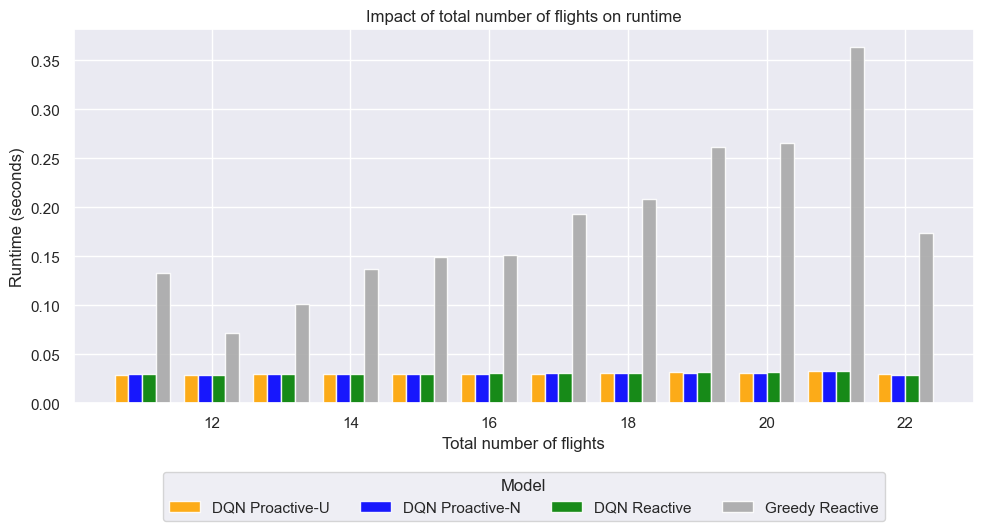

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get all unique flight counts and their scenarios
flight_counts = merged_df['TotalFlights'].unique()
flight_counts.sort()

print("Flight count statistics:")
for num_flights in flight_counts:
    scenarios = merged_df[merged_df['TotalFlights'] == num_flights]['Scenario'].unique()
    print(f"# scenarios with {num_flights} flights: {len(scenarios)}")

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else
        'darkgrey' if 'exact' in model_name.lower() else
        'green',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'myopic' in x.lower() else
                                        2 if 'reactive' in x.lower() else
                                        3))
}

# Aggregate data by taking the mean runtime for each (Model, TotalFlights)
agg_df = (
    merged_df
    .groupby(['Model', 'TotalFlights'], as_index=False)[['ScenarioTime']]
    .mean()
)

# Create a single figure
plt.figure(figsize=(10, 6))

# Calculate number of models and adjust bar width and spacing
n_models = len(model_colors)
bar_width = 0.2  # Width of each bar
total_width = bar_width * n_models
start_offset = -total_width/2 + bar_width/2  # Center the group of bars

# Plot bars for each model in the specified order
bar_offset = start_offset
for model_name, (color, label) in model_colors.items():
    model_data = agg_df[agg_df['Model'] == model_name].copy()
    # Sort by TotalFlights
    model_data = model_data.sort_values(by='TotalFlights')
    
    x = model_data['TotalFlights']
    y = model_data['ScenarioTime']
        
    plt.bar(
        x + bar_offset,  # Offset bars
        y,
        width=bar_width,
        label=label,
        color=color,
        alpha=0.9
    )
    bar_offset += bar_width  # Move to next position

plt.xlabel("Total number of flights")
plt.ylabel("Runtime (seconds)")
plt.title("Impact of total number of flights on runtime")
plt.grid(True, axis='y')

# Add legend
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.25), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Number of unique scenarios per bucket:
2385-2585 min: 11 scenarios
2585-2785 min: 44 scenarios
2785-2985 min: 87 scenarios
2985-3185 min: 118 scenarios
3185-3385 min: 134 scenarios
3385-3585 min: 125 scenarios
3585-3785 min: 112 scenarios
3785-3985 min: 50 scenarios
3985-4185 min: 16 scenarios
4185-4385 min: 2 scenarios


/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_91250/2597047443.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df


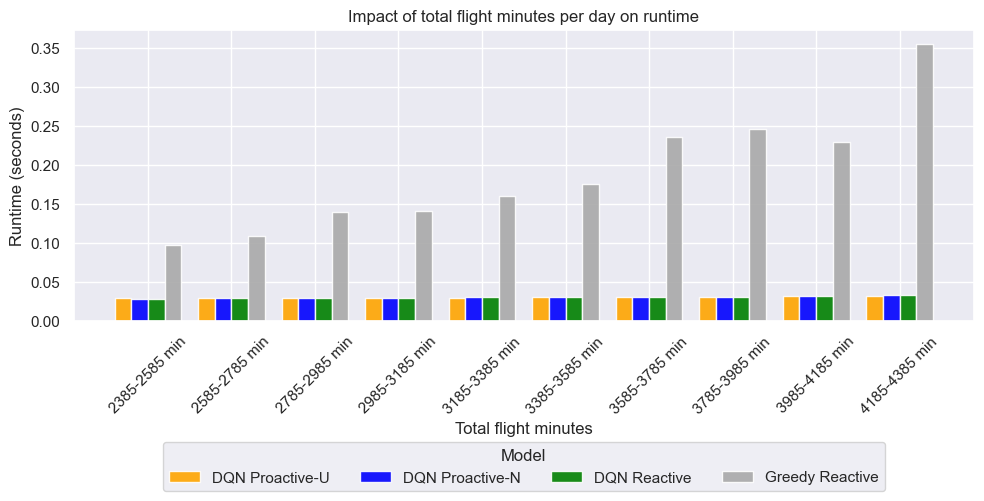

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else
        'darkgrey' if 'exact' in model_name.lower() else
        'green',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'myopic' in x.lower() else
                                        2 if 'reactive' in x.lower() else
                                        3))
}

# Calculate min and max flight minutes
min_minutes = merged_df['TotalFlightMinutes'].min()
max_minutes = merged_df['TotalFlightMinutes'].max()

# Create 4 equal-sized buckets of 30 minutes each
bucket_size = 200
bucket_edges = np.arange(min_minutes, max_minutes + bucket_size, bucket_size)

# Create bucket labels
bucket_labels = [
    f"{int(bucket_edges[i])}-{int(bucket_edges[i+1])} min" 
    for i in range(len(bucket_edges)-1)
]

# Add bucket column to merged_df
merged_df['Bucket'] = pd.cut(merged_df['TotalFlightMinutes'], 
                         bins=bucket_edges,
                         labels=bucket_labels)

# Print number of unique scenarios per bucket
print("Number of unique scenarios per bucket:")
for bucket in bucket_labels:
    n_scenarios = merged_df[merged_df['Bucket'] == bucket]['Scenario'].nunique()
    print(f"{bucket}: {n_scenarios} scenarios")

# Aggregate data by taking the mean runtime for each (Model, TotalFlightMinutes)
agg_df = (
    merged_df
    .groupby(['Model', 'TotalFlightMinutes'], as_index=False)[['ScenarioTime']]
    .mean()
)

# Add bucket column to aggregated data
agg_df['Bucket'] = pd.cut(agg_df['TotalFlightMinutes'], 
                         bins=bucket_edges,
                         labels=bucket_labels)

# Further aggregate by buckets
bucket_agg_df = (
    agg_df
    .groupby(['Model', 'Bucket'], as_index=False)[['ScenarioTime']]
    .mean()
)

# Create a single figure
plt.figure(figsize=(10, 8))  # Increased height from 6 to 8

# Calculate number of models and adjust bar width and spacing
n_models = len(model_colors)
bar_width = 0.2  # Width of each bar
total_width = bar_width * n_models
start_offset = -total_width/2 + bar_width/2  # Center the group of bars

# Plot bars for each model in the specified order
bar_offset = start_offset
for model_name, (color, label) in model_colors.items():
    model_data = bucket_agg_df[bucket_agg_df['Model'] == model_name].copy()
    # Sort by bucket
    model_data = model_data.sort_values(by='Bucket')
    
    x = np.arange(len(model_data['Bucket']))
    y = model_data['ScenarioTime']
        
    plt.bar(
        x + bar_offset,  # Offset bars
        y,
        width=bar_width,
        label=label,
        color=color,
        alpha=0.9
    )
    bar_offset += bar_width  # Move to next position

plt.xlabel("Total flight minutes")
plt.ylabel("Runtime (seconds)")
plt.title("Impact of total flight minutes per day on runtime")
plt.grid(True, axis='y')

# Set x-ticks to bucket labels
plt.xticks(np.arange(len(bucket_labels)), bucket_labels, rotation=45)

# Add legend with more space below
plt.legend(loc='center', bbox_to_anchor=(0.5, -0.5), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Adjusted bottom margin to accommodate legend
plt.show()


<div class="alert alert-block alert-warning">
</br>
</br>
<b>TO DO: </b>Impact of probability on delays & cancellations in stochastic scenarios
</br>
</br>
</br>
</div>

Number of unique scenarios in each bucket:
Bucket 0.00-0.05: 0 scenarios
Bucket 0.05-0.10: 0 scenarios
Bucket 0.10-0.15: 2 scenarios
Bucket 0.15-0.20: 11 scenarios
Bucket 0.20-0.25: 17 scenarios
Bucket 0.25-0.30: 13 scenarios
Bucket 0.30-0.35: 34 scenarios
Bucket 0.35-0.40: 31 scenarios
Bucket 0.40-0.45: 27 scenarios
Bucket 0.45-0.50: 20 scenarios
Bucket 0.50-0.55: 18 scenarios
Bucket 0.55-0.60: 22 scenarios
Bucket 0.60-0.65: 28 scenarios
Bucket 0.65-0.70: 29 scenarios
Bucket 0.70-0.75: 21 scenarios
Bucket 0.75-0.80: 17 scenarios
Bucket 0.80-0.85: 6 scenarios
Bucket 0.85-0.90: 4 scenarios
Bucket 0.90-0.95: 0 scenarios
Bucket 0.95-1.00: 0 scenarios


/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_91250/4069288240.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df


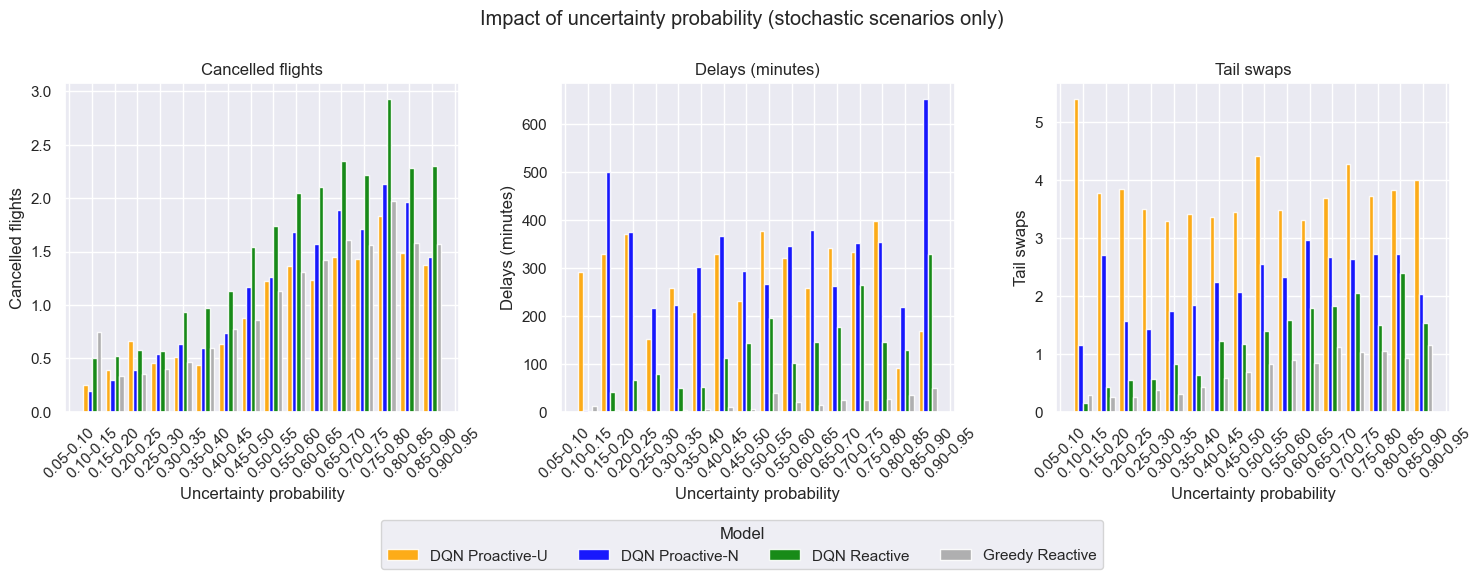

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else
        'darkgrey' if 'exact' in model_name.lower() else
        'green',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'myopic' in x.lower() else
                                        2 if 'reactive' in x.lower() else
                                        3))
}

# Define the metrics and corresponding y-axis labels in the specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps")
]

# Create a filtered copy for stochastic scenarios only
filtered_df = merged_df[merged_df['Scenario'].str.contains('stochastic', case=False)].copy()

# Create probability buckets of size 0.05
bucket_size = 0.05
bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
bucket_labels = [f"{bucket_edges[i]:.2f}-{bucket_edges[i+1]:.2f}" for i in range(len(bucket_edges)-1)]

# Create probability intervals using the defined buckets
filtered_df['ProbabilityInterval'] = pd.cut(filtered_df['AvgUncertaintyProbability'], 
                                    bins=bucket_edges,
                                    labels=bucket_labels,
                                    include_lowest=True)

# Print number of unique scenarios in each bucket
print("Number of unique scenarios in each bucket:")
for bucket in bucket_labels:
    scenario_count = filtered_df[filtered_df['ProbabilityInterval'] == bucket]['Scenario'].nunique()
    print(f"Bucket {bucket}: {scenario_count} scenarios")

# Aggregate data by taking the mean of the numeric metrics for each (Model, ProbabilityInterval)
agg_df = (
    filtered_df
    .groupby(['Model', 'ProbabilityInterval'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Remove rows where ProbabilityInterval has no actual values
agg_df = agg_df.dropna(subset=['ProbabilityInterval'])

# Define the display range for probability values
display_range = (0.05, 0.95)  # for example, only show intervals between 0.2 and 0.6

# Filter agg_df to only include intervals that lie fully within display_range
def interval_in_range(interval_label, low, high):
    start_str, end_str = interval_label.split('-')
    start_val = float(start_str)
    end_val = float(end_str)
    # Check if the entire interval lies within the specified range
    return start_val >= low and end_val <= high

agg_df = agg_df[agg_df['ProbabilityInterval'].apply(lambda x: interval_in_range(x, display_range[0], display_range[1]))]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

bar_width = 0.2  # Reduced to accommodate 4 bars

# Get only the filtered probability intervals
probability_intervals = sorted(agg_df['ProbabilityInterval'].unique())
x = np.arange(len(probability_intervals))

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Plot bars for each model in specific order
    model_order = ['DQN Proactive-U', 'DQN Proactive-N', 'DQN Reactive', 'Greedy Reactive']
    for j, desired_label in enumerate(model_order):
        # Find the model name that corresponds to this label
        matching_models = [name for name, (_, label) in model_colors.items() if label == desired_label]
        if not matching_models:
            continue
        model_name = matching_models[0]
        color = model_colors[model_name][0]
        
        model_data = agg_df[agg_df['Model'] == model_name]
        
        # Align model data with available probability intervals
        model_values = [
            model_data[model_data['ProbabilityInterval'] == interval][metric].iloc[0]
            if not model_data[model_data['ProbabilityInterval'] == interval].empty 
            else 0 
            for interval in probability_intervals
        ]
        
        ax.bar(x + j*bar_width, 
               model_values,
               bar_width,
               label=desired_label,
               color=color,
               alpha=0.9)
    
    ax.set_xlabel("Uncertainty probability")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.set_xticks(x + bar_width*1.5)  # Centered between bars
    ax.set_xticklabels(probability_intervals, rotation=45)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=4, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of uncertainty probability (stochastic scenarios only)", y=1.02)
plt.show()


Number of unique scenarios in each bucket:
Bucket 0.00-0.05: 0 scenarios
Bucket 0.05-0.10: 0 scenarios
Bucket 0.10-0.15: 2 scenarios
Bucket 0.15-0.20: 11 scenarios
Bucket 0.20-0.25: 17 scenarios
Bucket 0.25-0.30: 13 scenarios
Bucket 0.30-0.35: 34 scenarios
Bucket 0.35-0.40: 31 scenarios
Bucket 0.40-0.45: 27 scenarios
Bucket 0.45-0.50: 20 scenarios
Bucket 0.50-0.55: 18 scenarios
Bucket 0.55-0.60: 22 scenarios
Bucket 0.60-0.65: 28 scenarios
Bucket 0.65-0.70: 29 scenarios
Bucket 0.70-0.75: 21 scenarios
Bucket 0.75-0.80: 17 scenarios
Bucket 0.80-0.85: 6 scenarios
Bucket 0.85-0.90: 4 scenarios
Bucket 0.90-0.95: 0 scenarios
Bucket 0.95-1.00: 0 scenarios


/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_91250/782404294.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_df


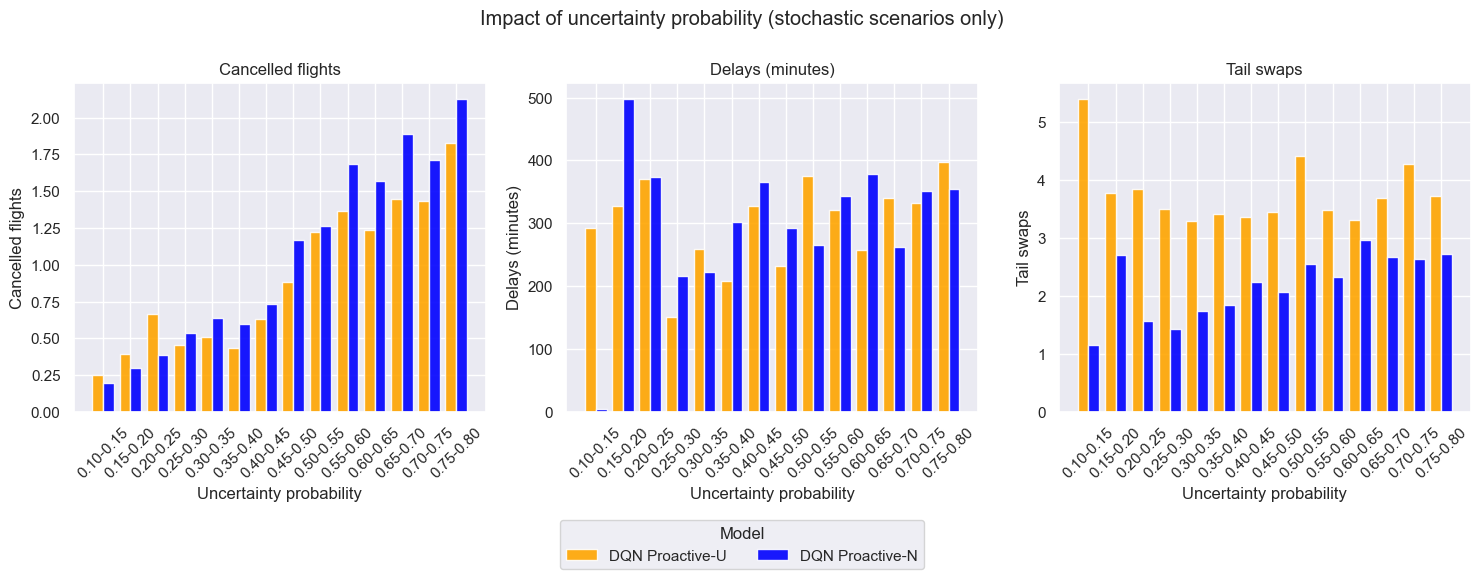

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'blue' if 'myopic' in model_name.lower() else
        'darkgrey' if 'exact' in model_name.lower() else
        'green',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'DQN Proactive-N' if 'myopic' in model_name.lower() else
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'myopic' in x.lower() else
                                        2 if 'reactive' in x.lower() else
                                        3))
}

# Define the metrics and corresponding y-axis labels in the specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps")
]

# Create a filtered copy for stochastic scenarios only
filtered_df = merged_df[merged_df['Scenario'].str.contains('stochastic', case=False)].copy()

# Create probability buckets of size 0.05
bucket_size = 0.05
bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
bucket_labels = [f"{bucket_edges[i]:.2f}-{bucket_edges[i+1]:.2f}" for i in range(len(bucket_edges)-1)]

# Create probability intervals using the defined buckets
filtered_df['ProbabilityInterval'] = pd.cut(filtered_df['AvgUncertaintyProbability'], 
                                    bins=bucket_edges,
                                    labels=bucket_labels,
                                    include_lowest=True)

# Print number of unique scenarios in each bucket
print("Number of unique scenarios in each bucket:")
for bucket in bucket_labels:
    scenario_count = filtered_df[filtered_df['ProbabilityInterval'] == bucket]['Scenario'].nunique()
    print(f"Bucket {bucket}: {scenario_count} scenarios")

# Aggregate data by taking the mean of the numeric metrics for each (Model, ProbabilityInterval)
agg_df = (
    filtered_df
    .groupby(['Model', 'ProbabilityInterval'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Remove rows where ProbabilityInterval has no actual values
agg_df = agg_df.dropna(subset=['ProbabilityInterval'])

# Define the display range for probability values
display_range = (0.1, 0.8)  # for example, only show intervals between 0.2 and 0.6

# Filter agg_df to only include intervals that lie fully within display_range
def interval_in_range(interval_label, low, high):
    start_str, end_str = interval_label.split('-')
    start_val = float(start_str)
    end_val = float(end_str)
    # Check if the entire interval lies within the specified range
    return start_val >= low and end_val <= high

agg_df = agg_df[agg_df['ProbabilityInterval'].apply(lambda x: interval_in_range(x, display_range[0], display_range[1]))]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

bar_width = 0.4  # Increased since we only have 2 bars now

# Get only the filtered probability intervals
probability_intervals = sorted(agg_df['ProbabilityInterval'].unique())
x = np.arange(len(probability_intervals))

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Plot bars for each model in specific order - only proactive models
    model_order = ['DQN Proactive-U', 'DQN Proactive-N']
    for j, desired_label in enumerate(model_order):
        # Find the model name that corresponds to this label
        matching_models = [name for name, (_, label) in model_colors.items() if label == desired_label]
        if not matching_models:
            continue
        model_name = matching_models[0]
        color = model_colors[model_name][0]
        
        model_data = agg_df[agg_df['Model'] == model_name]
        
        # Align model data with available probability intervals
        model_values = [
            model_data[model_data['ProbabilityInterval'] == interval][metric].iloc[0]
            if not model_data[model_data['ProbabilityInterval'] == interval].empty 
            else 0 
            for interval in probability_intervals
        ]
        
        ax.bar(x + j*bar_width, 
               model_values,
               bar_width,
               label=desired_label,
               color=color,
               alpha=0.9)
    
    ax.set_xlabel("Uncertainty probability")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.set_xticks(x + bar_width*0.5)  # Centered between bars
    ax.set_xticklabels(probability_intervals, rotation=45)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=2, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of uncertainty probability (stochastic scenarios only)", y=1.02)
plt.show()



Number of unique scenarios per disrupted flights bucket:
Disrupted flights = 0: 306 scenarios
Disrupted flights = 1: 265 scenarios
Disrupted flights = 2: 453 scenarios
Disrupted flights = 3: 344 scenarios
Disrupted flights = 4: 206 scenarios
Disrupted flights = 5: 80 scenarios
Disrupted flights = 6: 11 scenarios


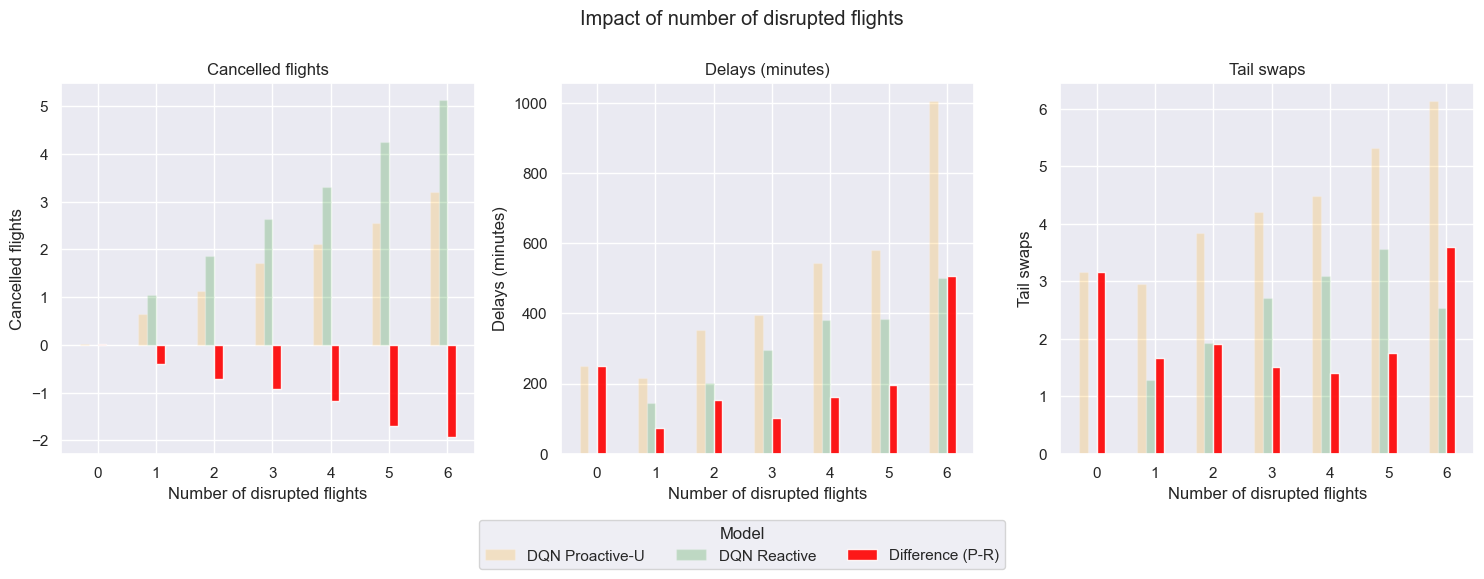

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'green' if 'exact' not in model_name.lower() else
        'darkgrey',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else 
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'reactive' in x.lower() else 
                                        2))
}

# Define the metrics and corresponding y-axis labels in specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps")
]

# Print number of unique scenarios per disrupted flights bucket
print("\nNumber of unique scenarios per disrupted flights bucket:")
scenario_counts = merged_df.groupby('ActualDisruptedFlights')['Scenario'].nunique()
for n_disrupted, n_scenarios in scenario_counts.items():
    print(f"Disrupted flights = {n_disrupted}: {n_scenarios} scenarios")

# Aggregate data by taking the mean of the numeric metrics for each (Model, ActualDisruptedFlights)
agg_df = (
    merged_df
    .groupby(['Model', 'ActualDisruptedFlights'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Calculate number of models and adjust bar width and spacing
    n_models = len([m for m in model_colors if 'exact' not in m.lower()]) + 1  # +1 for difference bar
    bar_width = 0.15  # Reduced bar width to accommodate bars
    total_width = bar_width * n_models
    start_offset = -total_width/2 + bar_width/2  # Center the group of bars
    
    # Plot bars for each model in the specified order
    bar_offset = start_offset
    proactive_values = None
    reactive_values = None
    
    for model_name, (color, label) in model_colors.items():
        if 'myopic' in model_name.lower() or 'exact' in model_name.lower():  # Skip myopic and exact models
            continue
            
        model_data = agg_df[agg_df['Model'] == model_name].copy()
        # Sort by ActualDisruptedFlights
        model_data = model_data.sort_values(by='ActualDisruptedFlights')
        
        x = model_data['ActualDisruptedFlights'].values
        y = model_data[metric].values
        
        if 'Proactive' in label:
            proactive_values = (x, y)
        elif 'Reactive' in label:
            reactive_values = (x, y)
            
        ax.bar(
            x + bar_offset,  # Offset bars
            y,
            width=bar_width,
            label=label,
            color=color,
            alpha=0.2
        )
        bar_offset += bar_width  # Move to next position
    
    # Add difference bar if we have both values
    if proactive_values and reactive_values:
        proactive_x, proactive_y = proactive_values
        reactive_x, reactive_y = reactive_values
        
        # Find common x values and align the arrays
        common_x = np.intersect1d(proactive_x, reactive_x)
        proactive_mask = np.isin(proactive_x, common_x)
        reactive_mask = np.isin(reactive_x, common_x)
        
        difference = proactive_y[proactive_mask] - reactive_y[reactive_mask]
        
        ax.bar(
            common_x + bar_offset,
            difference,
            width=bar_width,
            label='Difference (P-R)',
            color='red',
            alpha=0.9
        )

    ax.set_xlabel("Number of disrupted flights")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=3, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of number of disrupted flights", y=1.02)
plt.show()



Number of unique scenarios in each bucket:
Bucket 0.00-0.05: 0 scenarios
Bucket 0.05-0.10: 0 scenarios
Bucket 0.10-0.15: 0 scenarios
Bucket 0.15-0.20: 0 scenarios
Bucket 0.20-0.25: 0 scenarios
Bucket 0.25-0.30: 1 scenarios
Bucket 0.30-0.35: 34 scenarios
Bucket 0.35-0.40: 223 scenarios
Bucket 0.40-0.45: 297 scenarios
Bucket 0.45-0.50: 128 scenarios
Bucket 0.50-0.55: 17 scenarios
Bucket 0.55-0.60: 0 scenarios
Bucket 0.60-0.65: 0 scenarios
Bucket 0.65-0.70: 0 scenarios
Bucket 0.70-0.75: 0 scenarios
Bucket 0.75-0.80: 0 scenarios
Bucket 0.80-0.85: 0 scenarios
Bucket 0.85-0.90: 0 scenarios
Bucket 0.90-0.95: 0 scenarios
Bucket 0.95-1.00: 0 scenarios


/var/folders/m6/gwyqzldd12bg_s3mrl40tp6r0000gn/T/ipykernel_91250/1565427874.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df


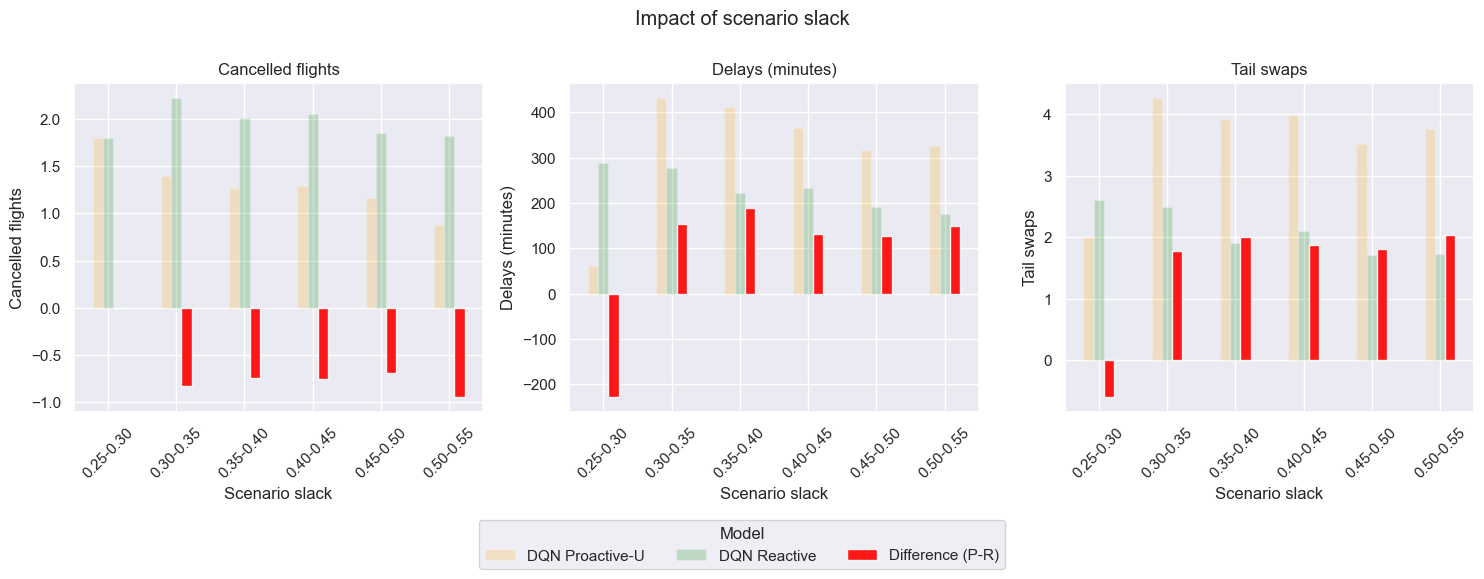

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a color map and human-readable labels for the models in specific order
model_colors = {
    model_name: (
        'orange' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else
        'green' if 'exact' not in model_name.lower() else
        'darkgrey',
        'DQN Proactive-U' if 'proactive' in model_name.lower() and 'myopic' not in model_name.lower() else 
        'DQN Reactive' if 'exact' not in model_name.lower() else
        'Greedy Reactive'
    )
    for model_name in sorted(merged_df['Model'].unique(), 
                           key=lambda x: (0 if 'proactive' in x.lower() and 'myopic' not in x.lower() else
                                        1 if 'reactive' in x.lower() else 
                                        2))
}

# Define the metrics and corresponding y-axis labels in specified order
metrics = [
    ("TotalCancelledFlights", "Cancelled flights"),
    ("TotalDelays", "Delays (minutes)"),
    ("TailSwaps", "Tail swaps")
]

# Create slack buckets of size 0.05
bucket_size = 0.05
bucket_edges = np.arange(0, 1 + bucket_size, bucket_size)
bucket_labels = [f"{bucket_edges[i]:.2f}-{bucket_edges[i+1]:.2f}" for i in range(len(bucket_edges)-1)]

# Create slack intervals using the defined buckets
merged_df['SlackInterval'] = pd.cut(merged_df['ScenarioSlack'], 
                                  bins=bucket_edges,
                                  labels=bucket_labels,
                                  include_lowest=True)

# Print number of unique scenarios in each bucket
print("\nNumber of unique scenarios in each bucket:")
for bucket in bucket_labels:
    scenario_count = merged_df[merged_df['SlackInterval'] == bucket]['Scenario'].nunique()
    print(f"Bucket {bucket}: {scenario_count} scenarios")

# Aggregate data by taking the mean of the numeric metrics for each (Model, SlackInterval)
agg_df = (
    merged_df
    .groupby(['Model', 'SlackInterval'], as_index=False)[[m[0] for m in metrics]]
    .mean()
)

# Remove rows where SlackInterval has no actual values
agg_df = agg_df.dropna(subset=['SlackInterval'])

# Define the display range for slack values
display_range = (0.25, 0.55)

# Filter agg_df to only include intervals that lie fully within display_range
def interval_in_range(interval_label, low, high):
    start_str, end_str = interval_label.split('-')
    start_val = float(start_str)
    end_val = float(end_str)
    return start_val >= low and end_val <= high

agg_df = agg_df[agg_df['SlackInterval'].apply(lambda x: interval_in_range(x, display_range[0], display_range[1]))]

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)

# Get only the filtered slack intervals
slack_intervals = sorted(agg_df['SlackInterval'].unique())
x = np.arange(len(slack_intervals))

bar_width = 0.15  # Reduced bar width to accommodate bars

for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    
    # Plot bars for each model in specific order
    bar_offset = -bar_width
    proactive_values = None
    reactive_values = None
    
    for model_name, (color, label) in model_colors.items():
        if 'myopic' in model_name.lower() or 'exact' in model_name.lower():  # Skip myopic and exact models
            continue
            
        model_data = agg_df[agg_df['Model'] == model_name]
        
        # Align model data with available slack intervals
        model_values = [
            model_data[model_data['SlackInterval'] == interval][metric].iloc[0]
            if not model_data[model_data['SlackInterval'] == interval].empty 
            else 0 
            for interval in slack_intervals
        ]
        
        if 'Proactive' in label:
            proactive_values = model_values
        elif 'Reactive' in label:
            reactive_values = model_values
            
        ax.bar(
            x + bar_offset,
            model_values,
            width=bar_width,
            label=label,
            color=color,
            alpha=0.2
        )
        bar_offset += bar_width
    
    # Add difference bar if we have both values
    if proactive_values and reactive_values:
        difference = np.array(proactive_values) - np.array(reactive_values)
        
        ax.bar(
            x + bar_offset,
            difference,
            width=bar_width,
            label='Difference (P-R)',
            color='red',
            alpha=0.9
        )

    ax.set_xlabel("Scenario slack")
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(slack_intervals, rotation=45)
    ax.grid(True, axis='y')

# Add a global legend (once for all subplots)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, -0.05), ncol=3, title="Model", frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Impact of scenario slack", y=1.02)
plt.show()
